<font color='blue' size="+3">Explainable Machine Learning Model for Anaemia prediction with improved accuracy</font>


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


<font color='blue' size="+2">Importing all the necessary libraries</font>


In [ ]:
!pip install catboost
!pip install lime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import missingno as msno
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    cohen_kappa_score, f1_score, roc_curve, roc_auc_score, auc,
    accuracy_score, classification_report, confusion_matrix,
    matthews_corrcoef, balanced_accuracy_score, precision_score,
    recall_score
)
from sklearn.ensemble import (
    RandomForestClassifier, BaggingClassifier, AdaBoostClassifier,
    GradientBoostingClassifier, ExtraTreesClassifier
)
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from tqdm import tqdm

import lime
from lime.lime_tabular import LimeTabularExplainer
from lime import lime_tabular


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=80bd2c475c55aae7c42ba5a26f1acfad58b4705772c9ee25210a9fc1384b67fd
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [ ]:
#   first read the data file
df= pd.read_csv('/content/SANHANES_2.csv')

<font color='blue' size="+2">Exploratory Data Analysis</font>


We need to explore/clean/filter it before processing it for machine learning It involves adding/deleting few columns or rows, joining some other data, and handling qualitative variables like dates.

In [ ]:
df.shape

(493, 43)

In [ ]:
df.head()

province  famhist_HighBP  weight_perception  weighloss_attempt_pastyear  \
0         6             NaN                NaN                         NaN   
1         7             NaN                NaN                         NaN   
2         8             NaN                NaN                         NaN   
3         2             NaN                NaN                         NaN   
4         5             NaN                NaN                         NaN   

   weightgain_attempt_pastyear  geotype  SBPfinal  DBPfinal  AGEfinal  Sex  \
0                          NaN        1     124.0      66.0        15    1   
1                          NaN        1     110.0      55.0        15    2   
2                          NaN        1     116.0      67.0        15    2   
3                          NaN        2     112.0      59.0        15    2   
4                          NaN        3     129.0      71.0        15    2   

   ...  redmeat  CategoricalFatScore  physical_activity  Healthcare_access2yr  \
0  ...      NaN                  NaN                NaN                   NaN   
1  ...      NaN                  NaN                NaN                   NaN   
2  ...      NaN                  NaN                NaN                   NaN   
3  ...      NaN                  NaN                NaN                   NaN   
4  ...      NaN                  NaN                NaN                   NaN   

   dwell_typ  medaid  WHratio_high  agric_animal  agric_crop  Hunger_cat  
0        NaN     NaN           2.0           NaN         NaN         NaN  
1        NaN     NaN           1.0           NaN         NaN         NaN  
2        1.0     2.0           1.0           2.0         2.0         1.0  
3        NaN     NaN           2.0           NaN         NaN         NaN  
4        2.0     2.0           2.0           NaN         NaN         3.0  

[5 rows x 43 columns]

In [ ]:
df.describe()

province  famhist_HighBP  weight_perception  \
count  493.000000      444.000000         440.000000   
mean     4.551724        1.840090           1.954545   
std      2.624126        0.497503           0.445404   
min      1.000000        1.000000           1.000000   
25%      2.000000        2.000000           2.000000   
50%      5.000000        2.000000           2.000000   
75%      7.000000        2.000000           2.000000   
max      9.000000        3.000000           4.000000   

       weighloss_attempt_pastyear  weightgain_attempt_pastyear     geotype  \
count                  437.000000                   438.000000  493.000000   
mean                     1.926773                     1.863014    2.182556   
std                      0.260807                     0.344226    1.141930   
min                      1.000000                     1.000000    1.000000   
25%                      2.000000                     2.000000    1.000000   
50%                      2.000000                     2.000000    2.000000   
75%                      2.000000                     2.000000    3.000000   
max                      2.000000                     2.000000    4.000000   

         SBPfinal    DBPfinal    AGEfinal         Sex  ...     redmeat  \
count  445.000000  442.000000  493.000000  493.000000  ...  435.000000   
mean   116.710112   64.993213   15.963489    1.535497  ...    1.057471   
std     12.353065    9.004028    0.861723    0.499245  ...    0.233009   
min     86.000000   45.000000   15.000000    1.000000  ...    1.000000   
25%    108.000000   58.000000   15.000000    1.000000  ...    1.000000   
50%    116.000000   64.000000   16.000000    2.000000  ...    1.000000   
75%    124.000000   71.000000   17.000000    2.000000  ...    1.000000   
max    180.000000  102.000000   17.000000    2.000000  ...    2.000000   

       CategoricalFatScore  physical_activity  Healthcare_access2yr  \
count           420.000000         440.000000            439.000000   
mean              1.600000           1.752273              1.685649   
std               0.490482           0.432184              0.464786   
min               1.000000           1.000000              1.000000   
25%               1.000000           2.000000              1.000000   
50%               2.000000           2.000000              2.000000   
75%               2.000000           2.000000              2.000000   
max               2.000000           2.000000              2.000000   

        dwell_typ      medaid  WHratio_high  agric_animal  agric_crop  \
count  439.000000  449.000000     467.00000    446.000000  446.000000   
mean     1.211845    1.910913       1.90364      1.946188    1.818386   
std      0.409082    0.285187       0.29540      0.225899    0.385959   
min      1.000000    1.000000       1.00000      1.000000    1.000000   
25%      1.000000    2.000000       2.00000      2.000000    2.000000   
50%      1.000000    2.000000       2.00000      2.000000    2.000000   
75%      1.000000    2.000000       2.00000      2.000000    2.000000   
max      2.000000    2.000000       2.00000      2.000000    2.000000   

       Hunger_cat  
count  453.000000  
mean     2.000000  
std      0.867302  
min      1.000000  
25%      1.000000  
50%      2.000000  
75%      3.000000  
max      3.000000  

[8 rows x 43 columns]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 493 entries, 0 to 492
Data columns (total 43 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   province                     493 non-null    int64  
 1   famhist_HighBP               444 non-null    float64
 2   weight_perception            440 non-null    float64
 3   weighloss_attempt_pastyear   437 non-null    float64
 4   weightgain_attempt_pastyear  438 non-null    float64
 5   geotype                      493 non-null    int64  
 6   SBPfinal                     445 non-null    float64
 7   DBPfinal                     442 non-null    float64
 8   AGEfinal                     493 non-null    int64  
 9   Sex                          493 non-null    int64  
 10  foodexpense                  450 non-null    float64
 11  familymembhungry_pastyear    448 non-null    float64
 12  distance_clinic              448 non-null    float64
 13  HHlivingcost        

In [ ]:
value_counts_dict = {}

# Loop through each column in the DataFrame
for col in df.columns:
    # Calculate value counts for the current column and store it in the dictionary
    value_counts_dict[col] = df[col].value_counts()

# Print the value counts for each feature in a structured format
for col, counts in value_counts_dict.items():
    print(f"--- Value counts for feature '{col}' ---")
    print(counts)
    print("\n")  # Add a newline for readability between features


--- Value counts for feature 'province' ---
province
2    86
1    77
6    65
5    65
8    44
9    44
4    44
7    38
3    30
Name: count, dtype: int64


--- Value counts for feature 'famhist_HighBP' ---
famhist_HighBP
2.0    323
1.0     96
3.0     25
Name: count, dtype: int64


--- Value counts for feature 'weight_perception' ---
weight_perception
2.0    355
1.0     53
3.0     31
4.0      1
Name: count, dtype: int64


--- Value counts for feature 'weighloss_attempt_pastyear' ---
weighloss_attempt_pastyear
2.0    405
1.0     32
Name: count, dtype: int64


--- Value counts for feature 'weightgain_attempt_pastyear' ---
weightgain_attempt_pastyear
2.0    378
1.0     60
Name: count, dtype: int64


--- Value counts for feature 'geotype' ---
geotype
1    209
3    149
4     75
2     60
Name: count, dtype: int64


--- Value counts for feature 'SBPfinal' ---
SBPfinal
120.0    21
110.0    19
108.0    17
116.0    15
121.0    15
         ..
152.0     1
88.0      1
150.0     1
90.0      1
92.0      

In [ ]:
df.columns

Index(['province', 'famhist_HighBP', 'weight_perception',
       'weighloss_attempt_pastyear', 'weightgain_attempt_pastyear', 'geotype',
       'SBPfinal', 'DBPfinal', 'AGEfinal', 'Sex', 'foodexpense',
       'familymembhungry_pastyear', 'distance_clinic', 'HHlivingcost', 'VitA',
       'ferritin_res_edited', 'platelet_count_res1', 'hh_incomecat', 'bmi',
       'sugarscore_cat', 'fruitscore_cat', 'NutriKnowA_cat', 'WHODASscore',
       'HDL', 'mcv_res', 'aindex_cat', 'HbA1c', 'anemia_bin', 'Race', 'DDScat',
       'Psych_dist2', 'Cursmoker', 'leafyveg', 'redmeat',
       'CategoricalFatScore', 'physical_activity', 'Healthcare_access2yr',
       'dwell_typ', 'medaid', 'WHratio_high', 'agric_animal', 'agric_crop',
       'Hunger_cat'],
      dtype='object')

In [ ]:
df.isnull().sum()

province                         0
famhist_HighBP                  49
weight_perception               53
weighloss_attempt_pastyear      56
weightgain_attempt_pastyear     55
geotype                          0
SBPfinal                        48
DBPfinal                        51
AGEfinal                         0
Sex                              0
foodexpense                     43
familymembhungry_pastyear       45
distance_clinic                 45
HHlivingcost                    48
VitA                           345
ferritin_res_edited            312
platelet_count_res1              0
hh_incomecat                     0
bmi                             25
sugarscore_cat                  73
fruitscore_cat                  60
NutriKnowA_cat                  83
WHODASscore                     75
HDL                              8
mcv_res                          0
aindex_cat                     132
HbA1c                           85
anemia_bin                       0
Race                

<Axes: >

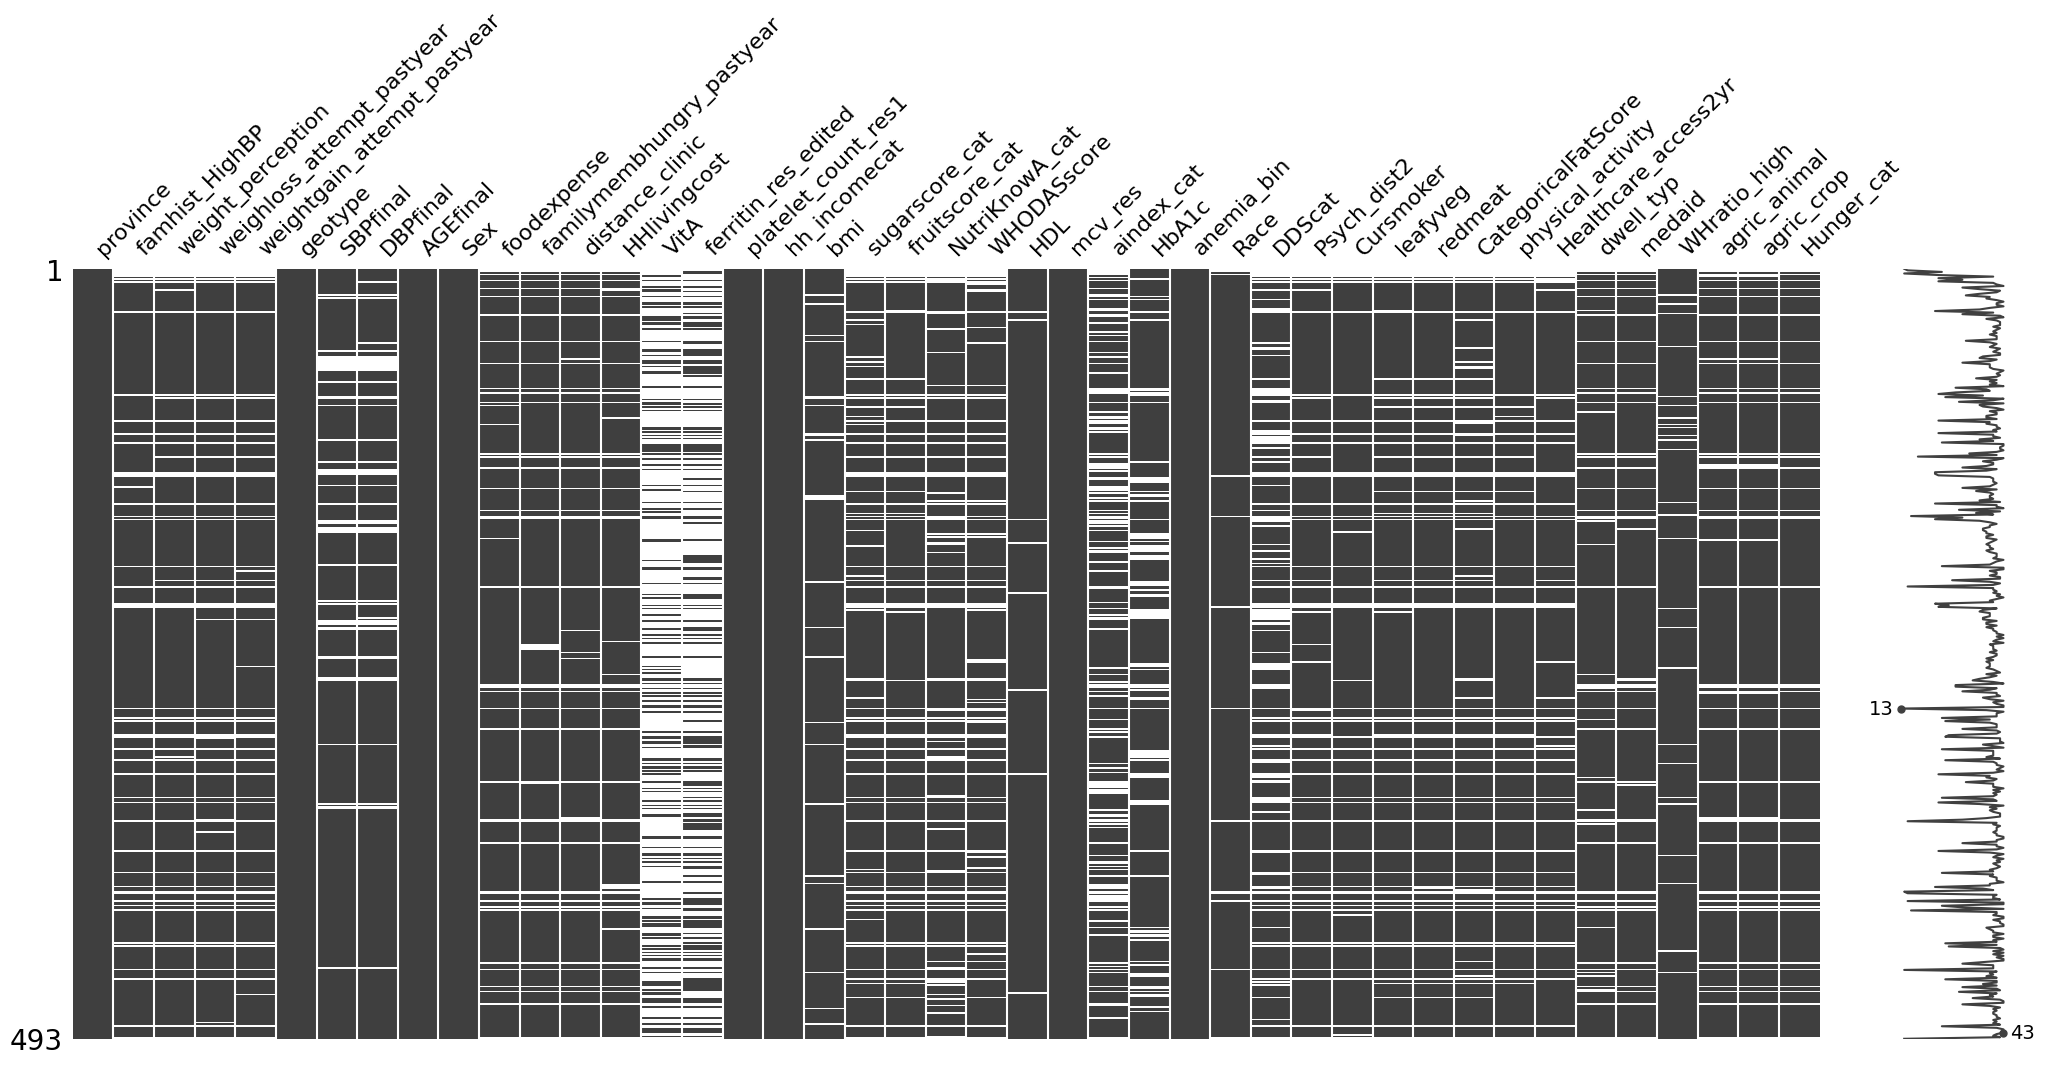

In [ ]:
# Visualize missing data
msno.matrix(df)


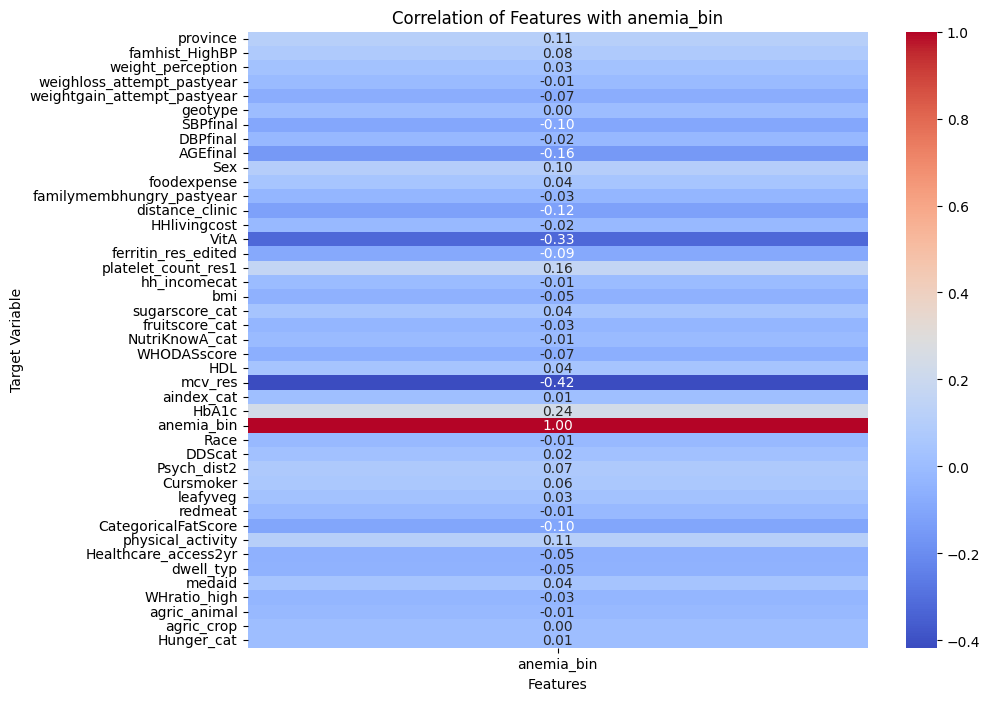

In [ ]:



# Compute Pearson correlation coefficients
corr_matrix = df.corr()

# Extract correlations of features with the target variable
target_corr = corr_matrix['anemia_bin']

# Plot heatmap of correlations
plt.figure(figsize=(10, 8))
sns.heatmap(target_corr.to_frame(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation of Features with anemia_bin')
plt.xlabel('Features')
plt.ylabel('Target Variable')
plt.show()


<font color='blue' size="+1">Handling Missing Values</font>


In [ ]:
# Calculate percentage of missing values per feature
missing_percentage = (df.isnull().sum() / len(df)) * 100
missing_percentage

province                        0.000000
famhist_HighBP                  9.939148
weight_perception              10.750507
weighloss_attempt_pastyear     11.359026
weightgain_attempt_pastyear    11.156187
geotype                         0.000000
SBPfinal                        9.736308
DBPfinal                       10.344828
AGEfinal                        0.000000
Sex                             0.000000
foodexpense                     8.722110
familymembhungry_pastyear       9.127789
distance_clinic                 9.127789
HHlivingcost                    9.736308
VitA                           69.979716
ferritin_res_edited            63.286004
platelet_count_res1             0.000000
hh_incomecat                    0.000000
bmi                             5.070994
sugarscore_cat                 14.807302
fruitscore_cat                 12.170385
NutriKnowA_cat                 16.835700
WHODASscore                    15.212982
HDL                             1.622718
mcv_res         

In [ ]:
# Set the threshold percentage
threshold = 30

# Filter out features with missing percentages above the threshold
high_missing_features = [feature for feature, percentage in missing_percentage.items() if percentage > threshold]

# Drop the high missing features from the DataFrame
df.drop(columns=high_missing_features, inplace=True)

# Print the names of the dropped features
print("Dropped features with high missing percentages:", high_missing_features)


Dropped features with high missing percentages: ['VitA', 'ferritin_res_edited']


In [ ]:
df.shape

(493, 41)

<font color='blue' size="+1"> Visualize some data</font>


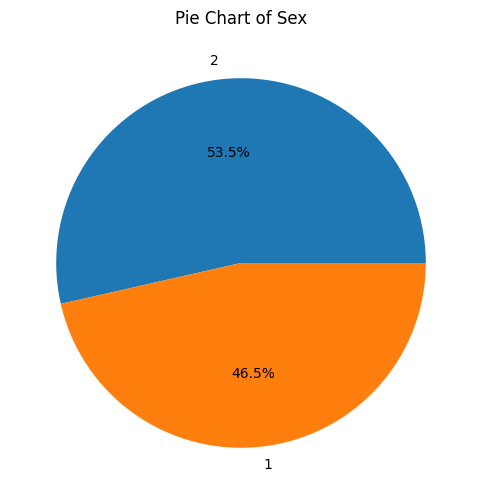

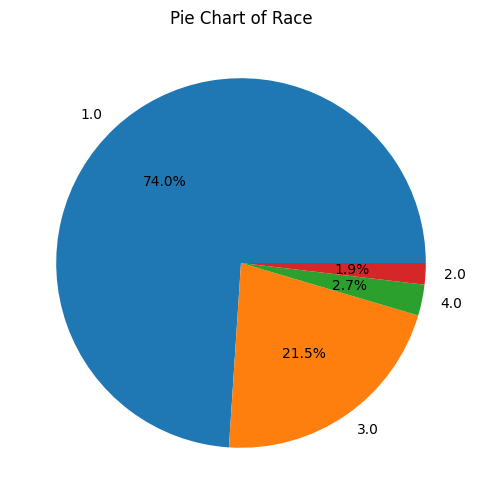

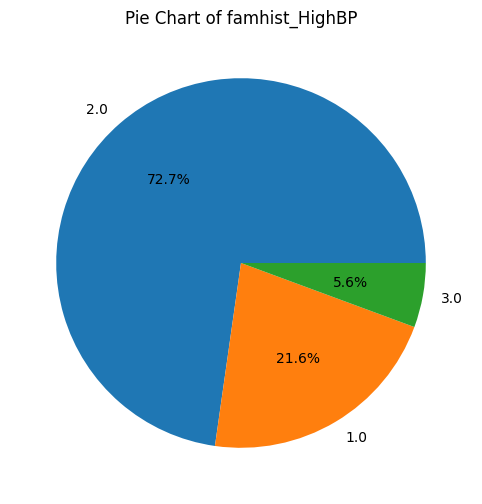

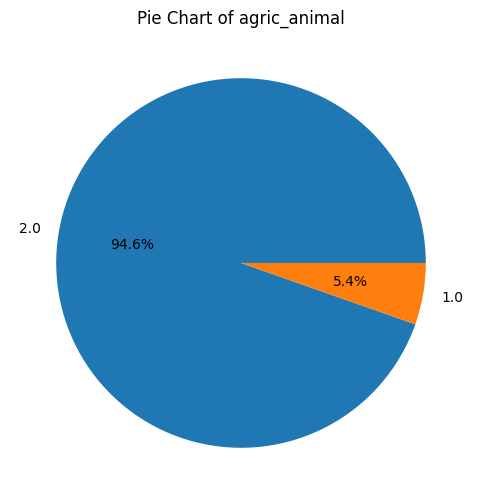

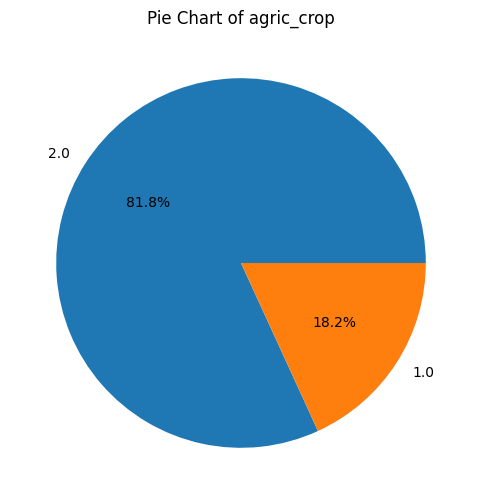

In [ ]:
numerical_features = ['SBPfinal', 'DBPfinal', 'AGEfinal', 'bmi', 'HbA1c']
categorical_features = ['Sex', 'Race', 'famhist_HighBP', 'agric_animal', 'agric_crop']

# Pie charts
for feature in categorical_features:
    plt.figure(figsize=(8, 6))
    df[feature].value_counts().plot.pie(autopct='%1.1f%%')
    plt.title(f'Pie Chart of {feature}')
    plt.ylabel('')
    plt.show()

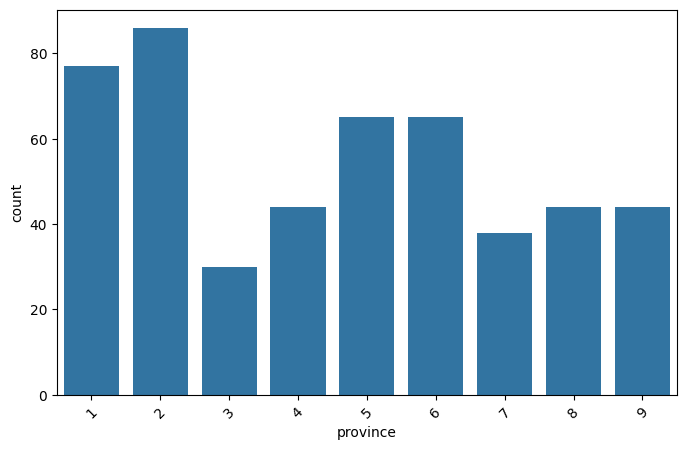

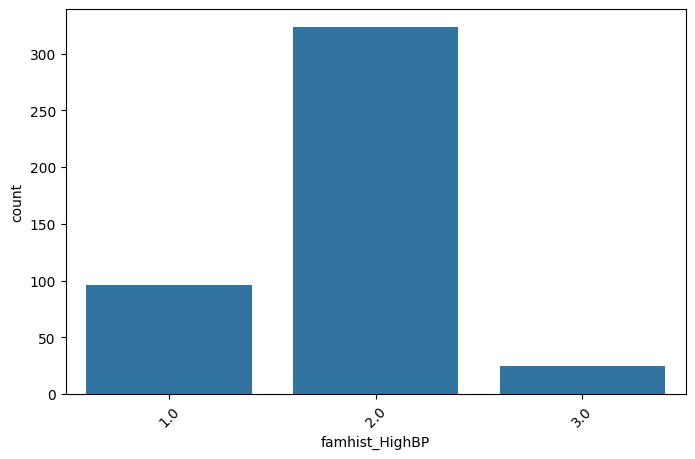

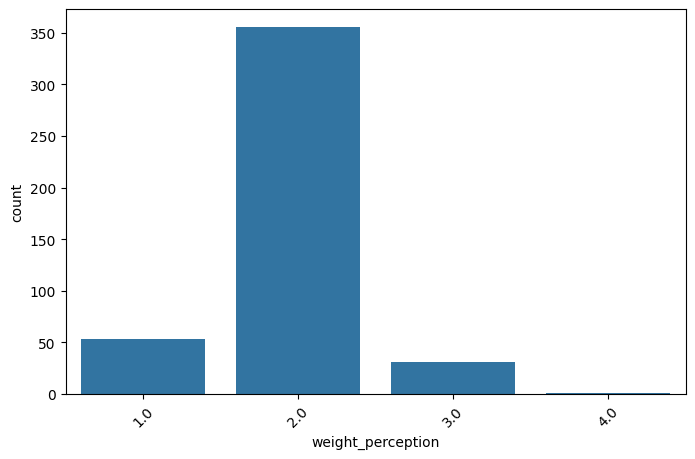

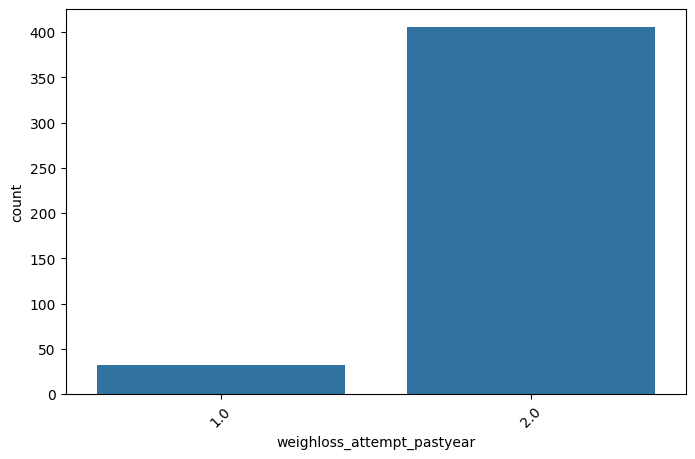

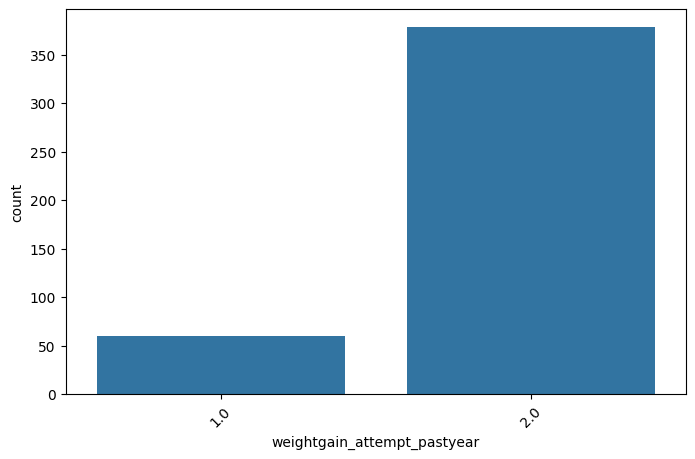

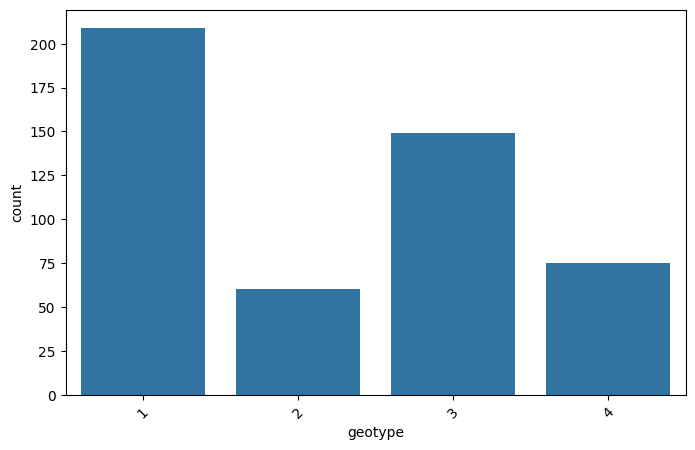

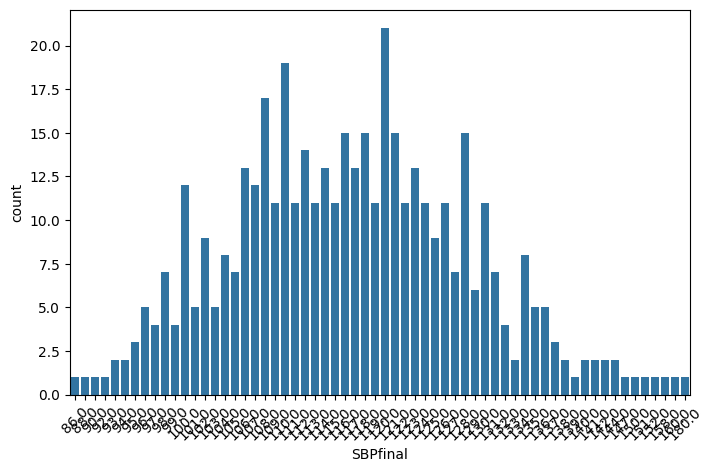

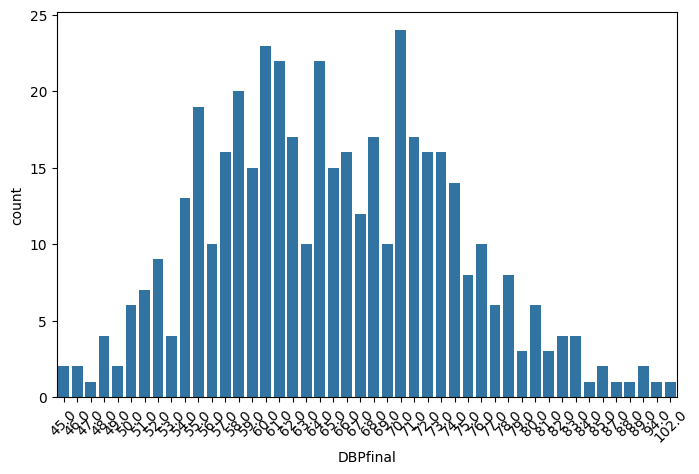

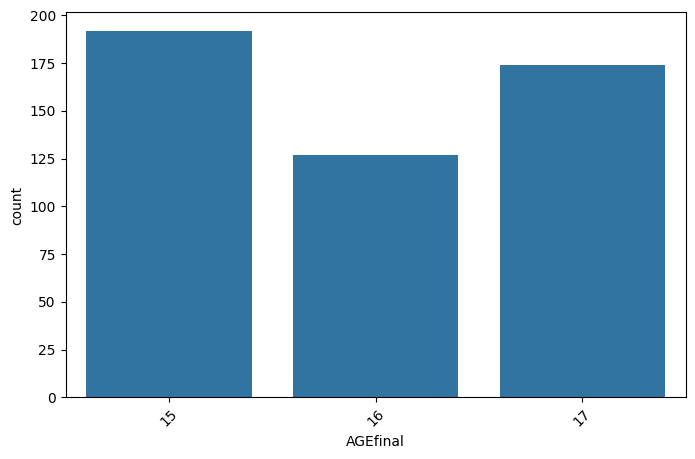

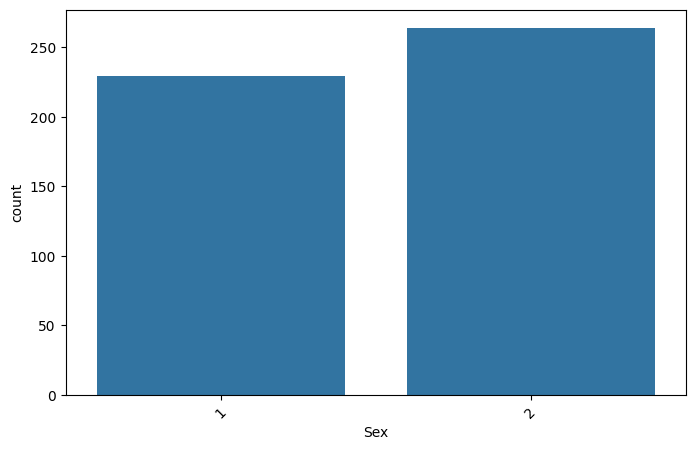

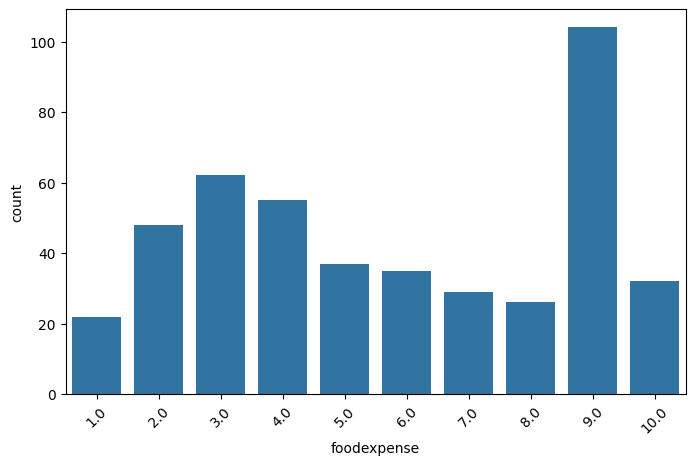

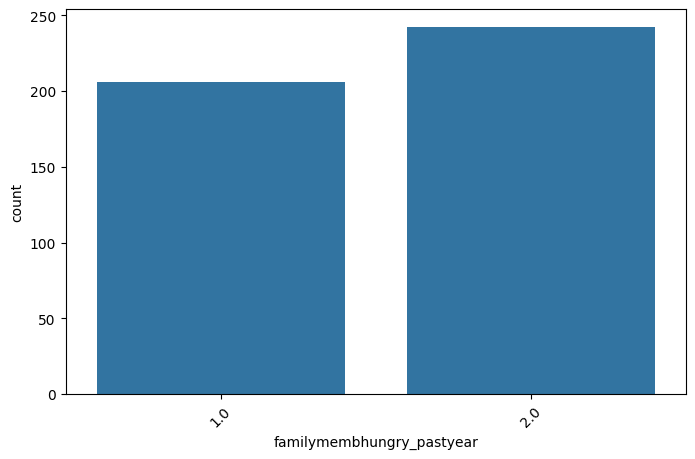

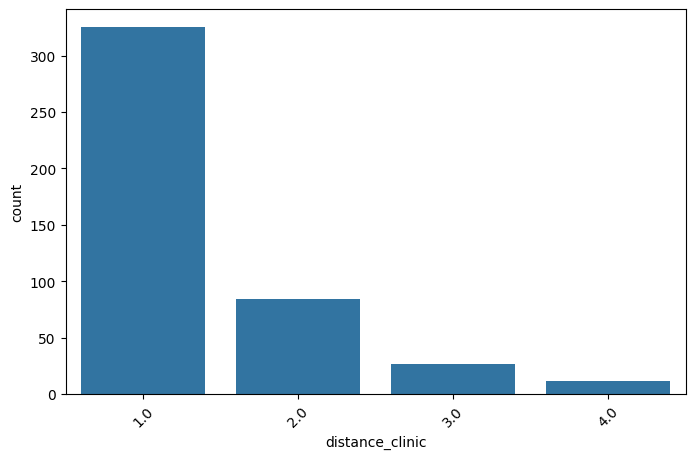

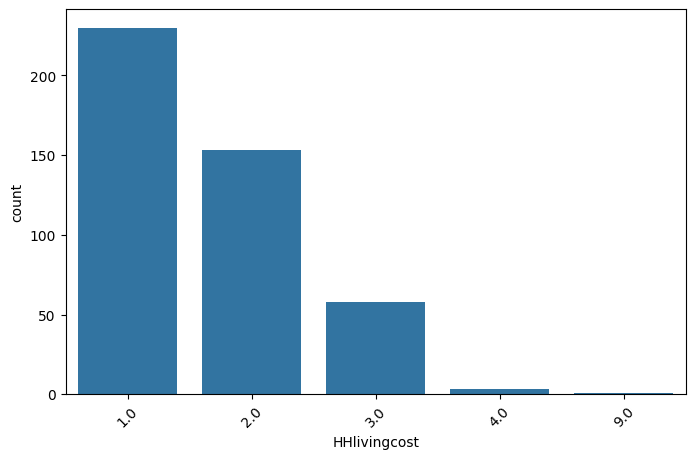

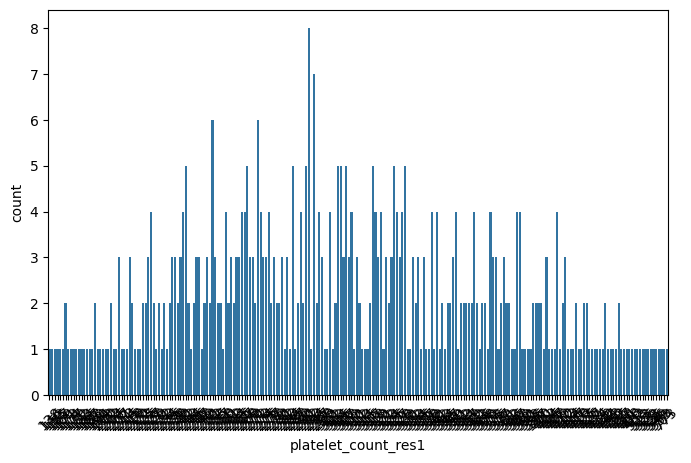

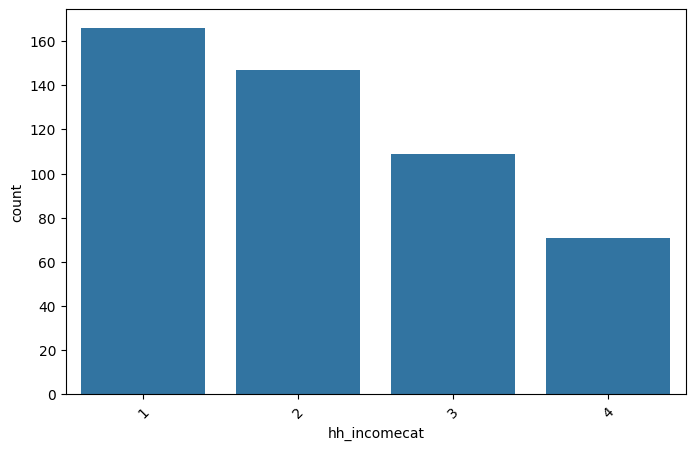

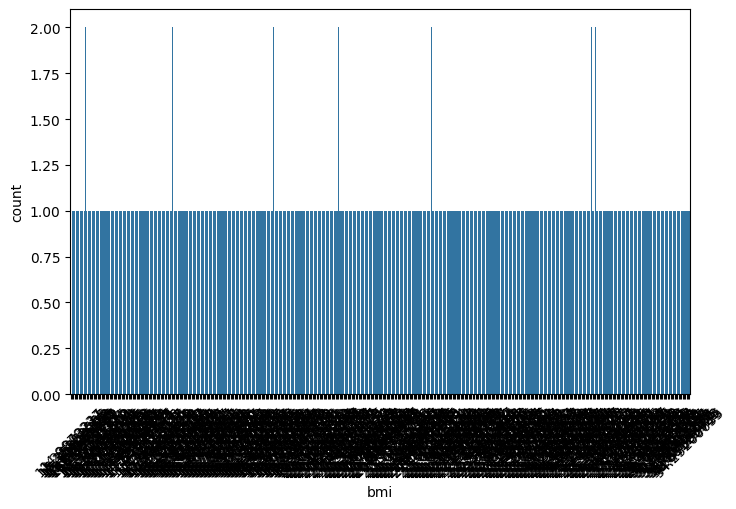

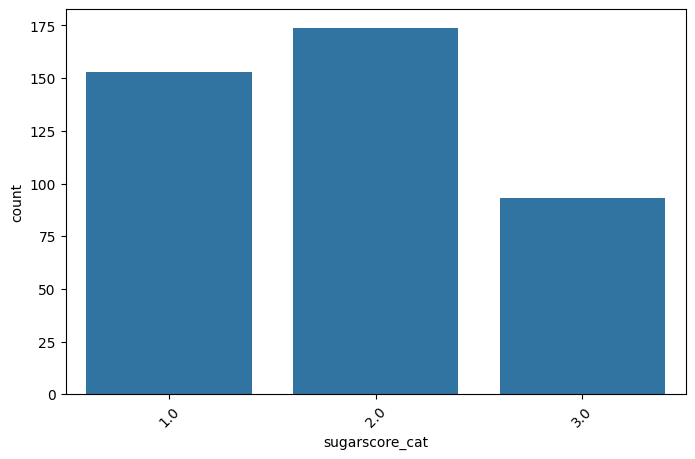

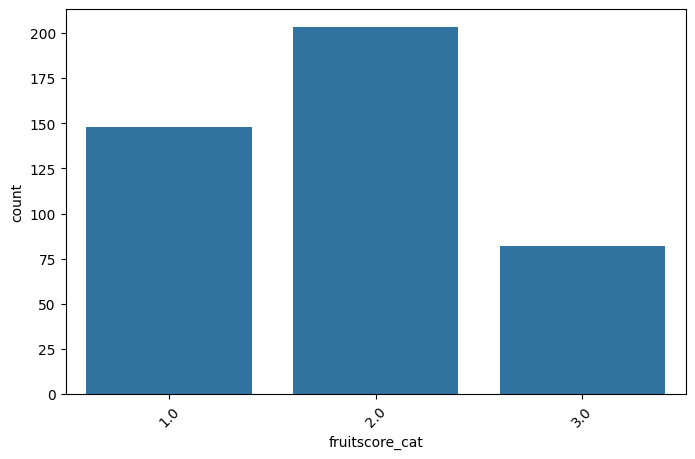

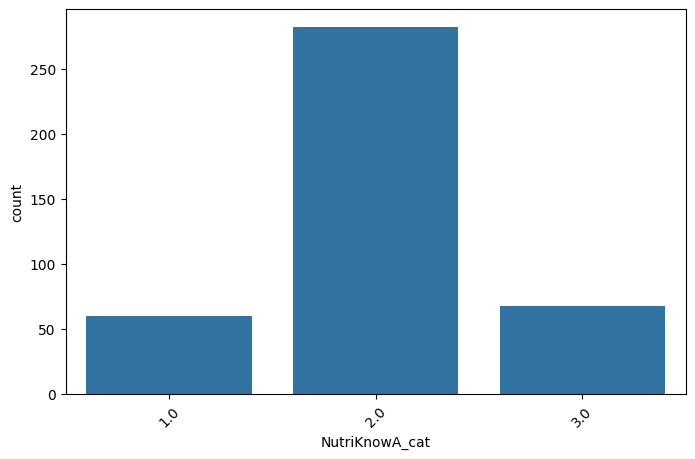

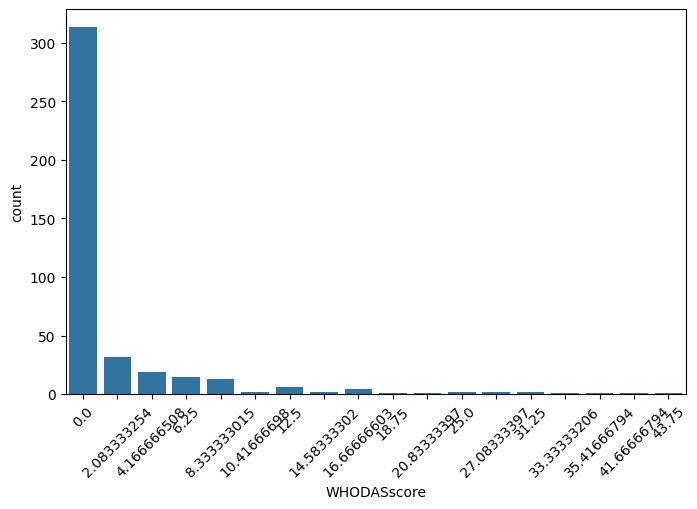

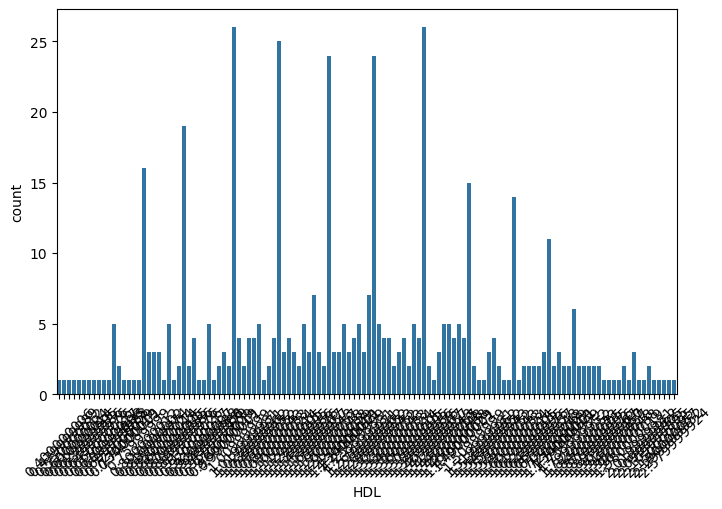

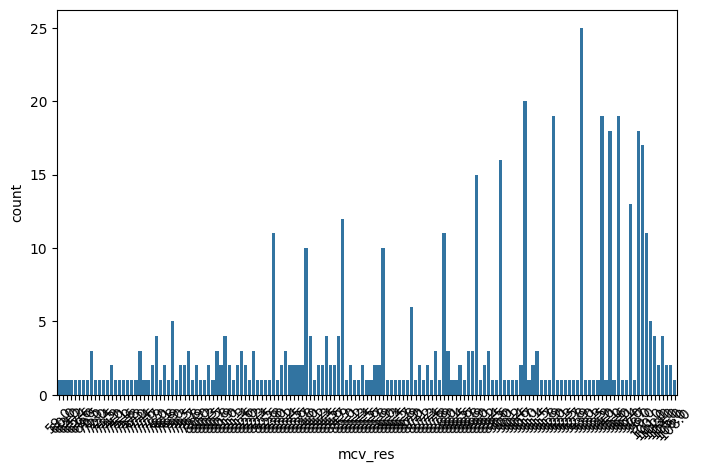

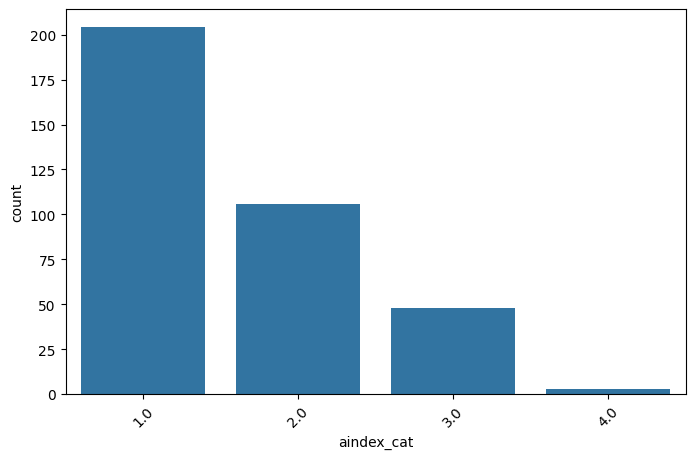

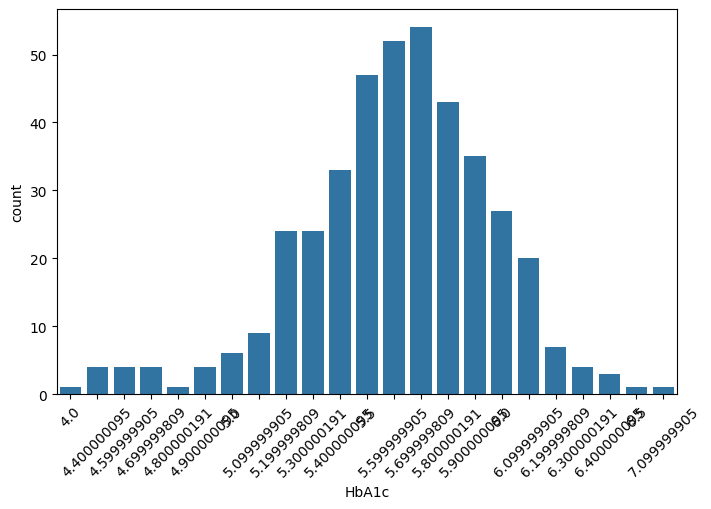

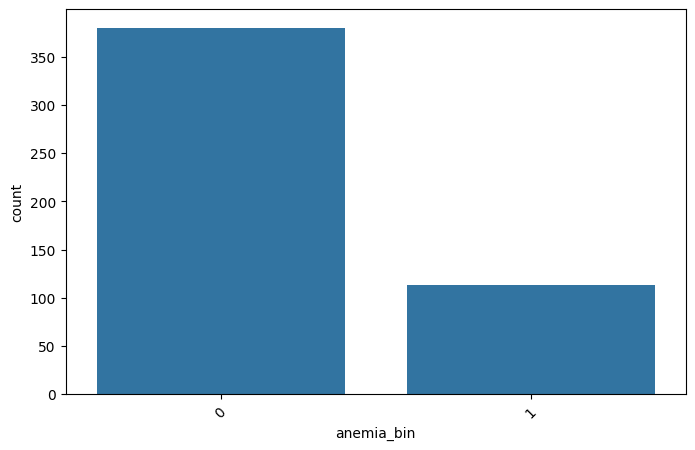

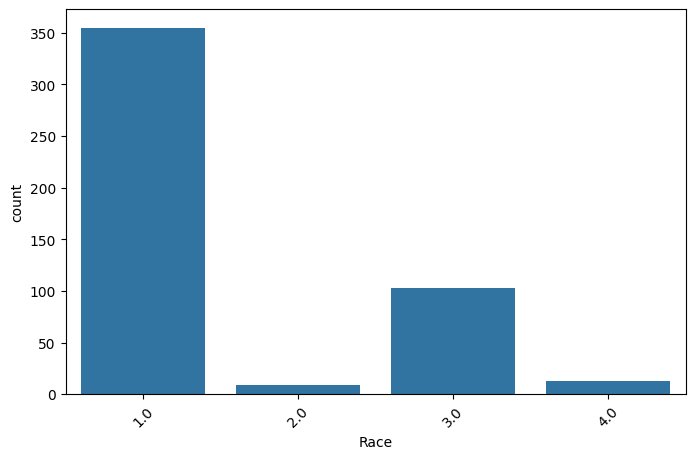

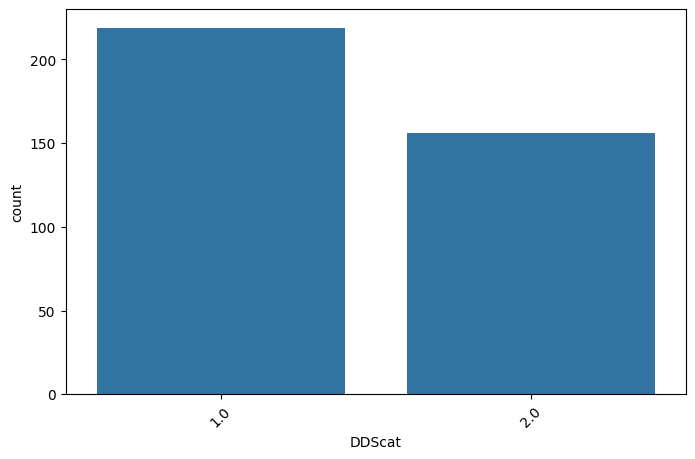

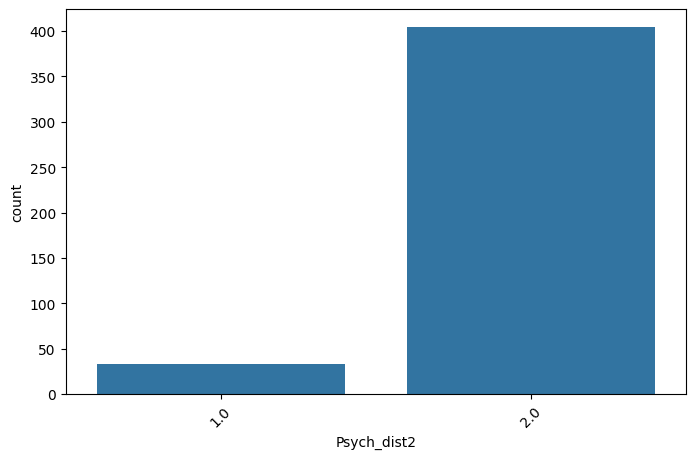

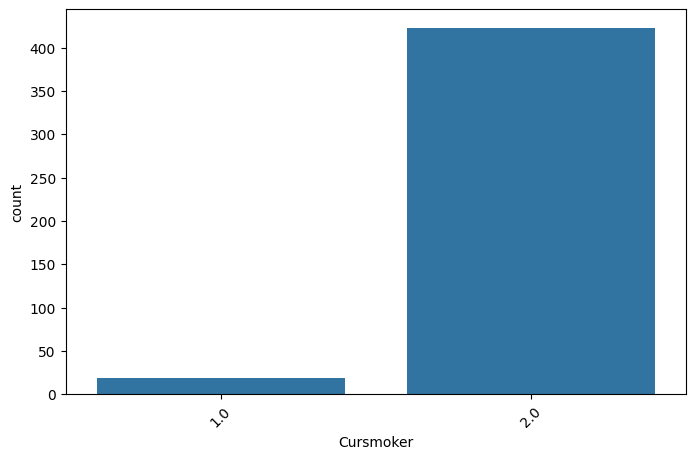

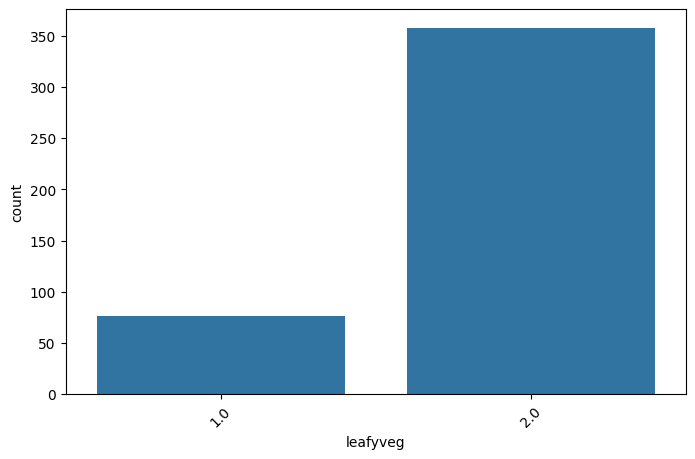

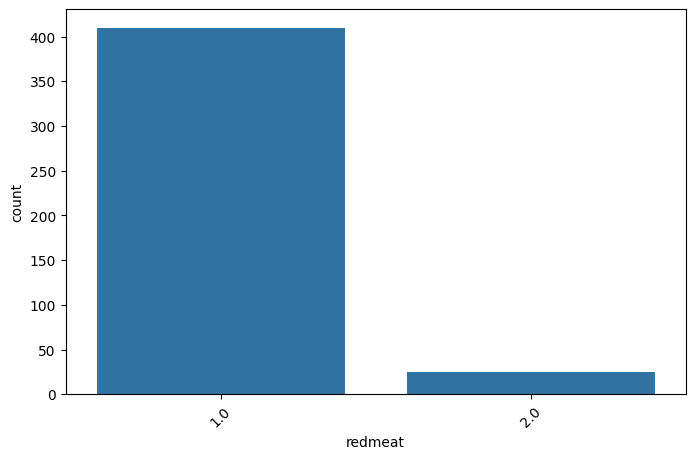

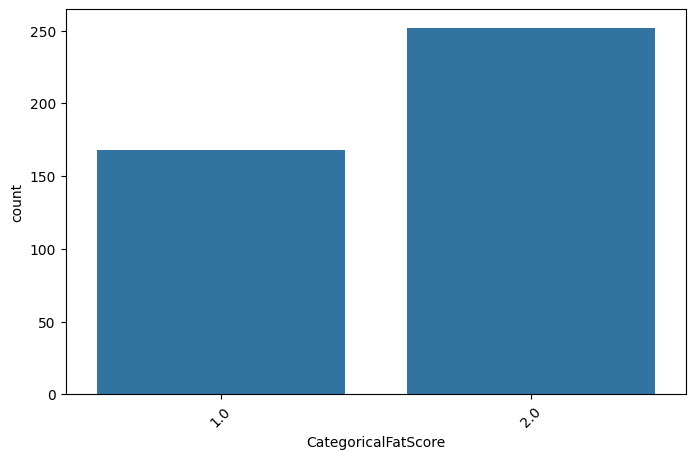

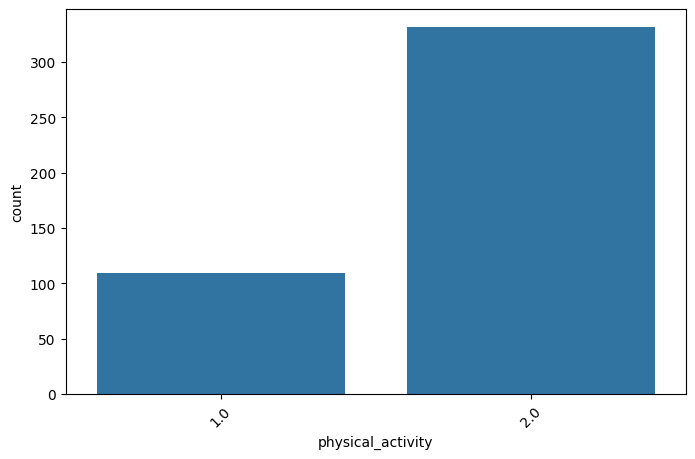

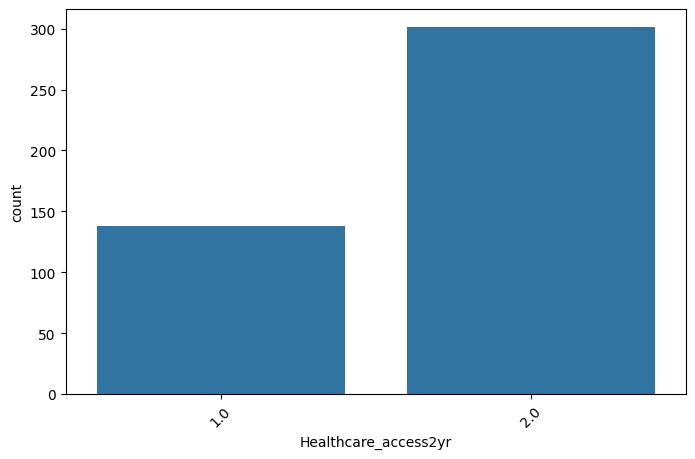

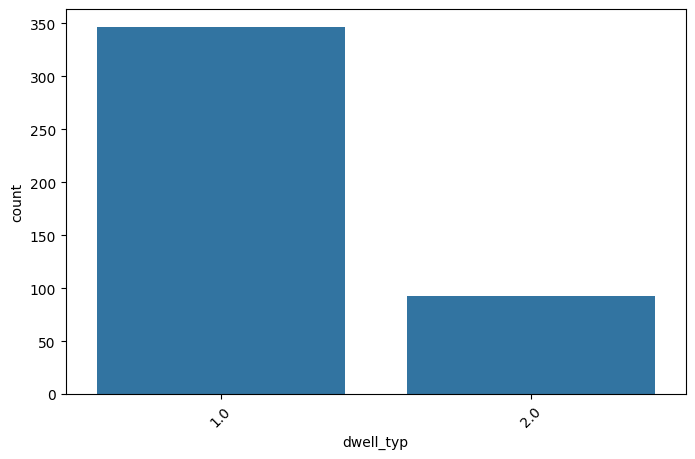

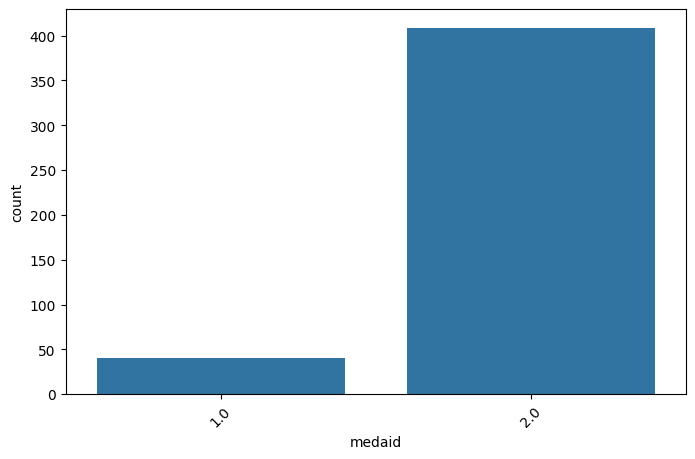

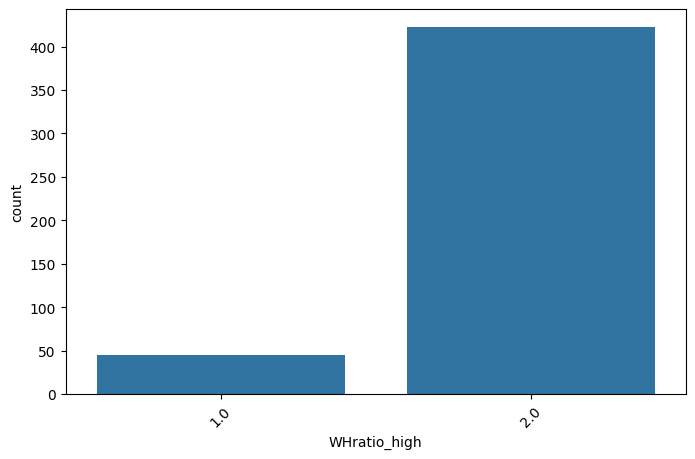

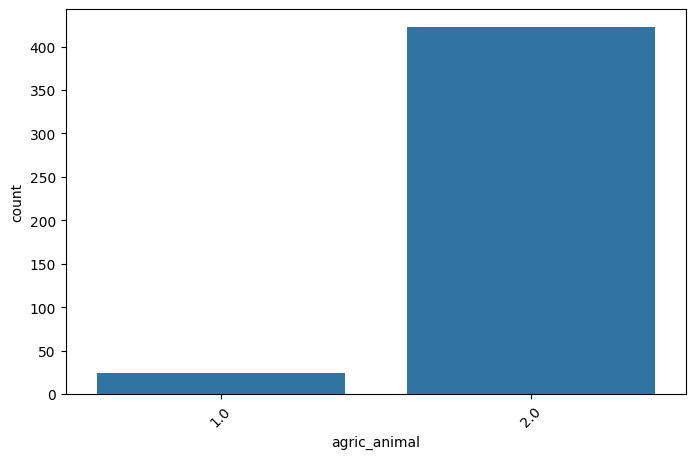

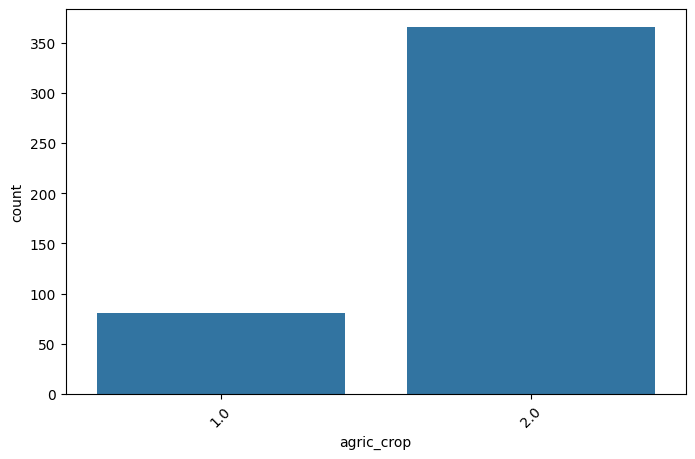

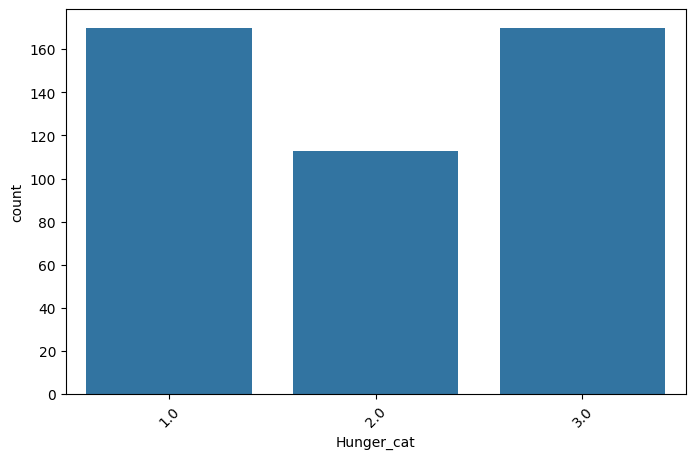

In [ ]:
categorical_columns = df.select_dtypes(include=['int64','float64'])
for col in categorical_columns.columns:
    plt.figure(figsize=(8, 5))
    sns.countplot(data=df, x=col)
    plt.xticks(rotation=45)
    plt.show()


<font color='blue' size="+3">Feature Selection</font>


In [ ]:
X = df.drop(columns=['anemia_bin'])  # Features
y = df['anemia_bin']  # Target variable

# Calculate the correlation coefficients between features and the target variable
correlation_scores = X.corrwith(y)

# Select features with correlation coefficient above a threshold (e.g., 0.1)
selected_features = correlation_scores[abs(correlation_scores) > 0.05].index.tolist()

selected_features.append('anemia_bin')

# Create a new DataFrame with selected features and target variable
df_selected = df[selected_features]
# Print the selected features
print("Selected features:", selected_features)


Selected features: ['province', 'famhist_HighBP', 'weightgain_attempt_pastyear', 'SBPfinal', 'AGEfinal', 'Sex', 'distance_clinic', 'platelet_count_res1', 'bmi', 'WHODASscore', 'mcv_res', 'HbA1c', 'Psych_dist2', 'Cursmoker', 'CategoricalFatScore', 'physical_activity', 'Healthcare_access2yr', 'anemia_bin']


In [ ]:
df_copy = df_selected.copy()

In [ ]:
df_copy.shape

(493, 18)

<font color='blue' size="+1">Data Preprocessing</font>


In [ ]:
# Round the mean to the nearest whole number for all columns
mean_rounded = df_copy.mean().round()

# Fill missing values with rounded mean for all columns
df = df_copy.fillna(mean_rounded)

# Checking if there are any remaining missing values
missing_values_after_imputation = df.isnull().sum()
print(missing_values_after_imputation)


province                       0
famhist_HighBP                 0
weightgain_attempt_pastyear    0
SBPfinal                       0
AGEfinal                       0
Sex                            0
distance_clinic                0
platelet_count_res1            0
bmi                            0
WHODASscore                    0
mcv_res                        0
HbA1c                          0
Psych_dist2                    0
Cursmoker                      0
CategoricalFatScore            0
physical_activity              0
Healthcare_access2yr           0
anemia_bin                     0
dtype: int64


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 493 entries, 0 to 492
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   province                     493 non-null    int64  
 1   famhist_HighBP               493 non-null    float64
 2   weightgain_attempt_pastyear  493 non-null    float64
 3   SBPfinal                     493 non-null    float64
 4   AGEfinal                     493 non-null    int64  
 5   Sex                          493 non-null    int64  
 6   distance_clinic              493 non-null    float64
 7   platelet_count_res1          493 non-null    int64  
 8   bmi                          493 non-null    float64
 9   WHODASscore                  493 non-null    float64
 10  mcv_res                      493 non-null    float64
 11  HbA1c                        493 non-null    float64
 12  Psych_dist2                  493 non-null    float64
 13  Cursmoker           

In [ ]:
df_copy = df.copy()

In [ ]:
df_copy.shape

(493, 18)

In [ ]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 493 entries, 0 to 492
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   province                     493 non-null    int64  
 1   famhist_HighBP               493 non-null    float64
 2   weightgain_attempt_pastyear  493 non-null    float64
 3   SBPfinal                     493 non-null    float64
 4   AGEfinal                     493 non-null    int64  
 5   Sex                          493 non-null    int64  
 6   distance_clinic              493 non-null    float64
 7   platelet_count_res1          493 non-null    int64  
 8   bmi                          493 non-null    float64
 9   WHODASscore                  493 non-null    float64
 10  mcv_res                      493 non-null    float64
 11  HbA1c                        493 non-null    float64
 12  Psych_dist2                  493 non-null    float64
 13  Cursmoker           

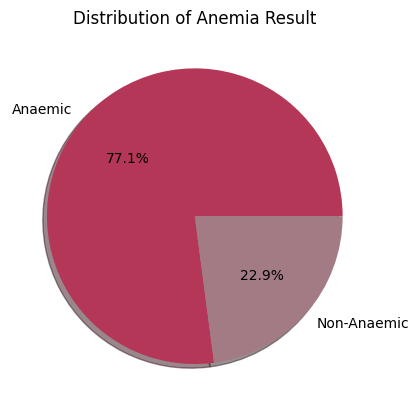

In [ ]:
# Create a pie chart of the distribution of anemia result
# Define labels and colors
custom_colors = ['#B43757', '#a37b85']
labels = ['Anaemic', 'Non-Anaemic']

# Assuming df_copy['anemia_bin'].value_counts() returns counts for Anaemia and Non-Anaemic
result_counts = df_copy['anemia_bin'].value_counts()

# Create pie chart
plt.pie(result_counts, labels=labels, autopct='%1.1f%%', colors=custom_colors, shadow=True)
plt.title('Distribution of Anemia Result')
plt.show()


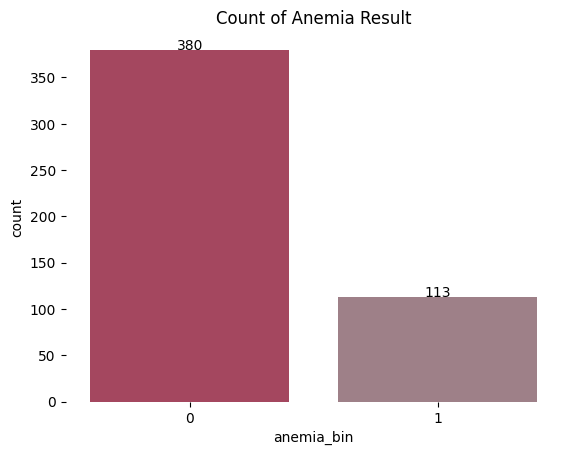

In [ ]:
# Create a count plot of the anemia result
ax = sns.countplot(x='anemia_bin', data=df_copy, palette=custom_colors)
plt.title('Count of Anemia Result')

# Add labels to the bars
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2, height + 0.1, '{:.0f}'.format(height), ha='center')

# Remove spines
sns.despine(left=True, bottom=True)

plt.show()


 We can see clearly that we have an imbalanced dataset which indicates that 77.1% of the population don't have anemia and 22.9% has anemia. we need to address the class imbalance in our data before building a predictive model

Imbalanced classes can cause issues in machine learning models, as the model may be biased towards the majority class and may not perform well on the minority class.

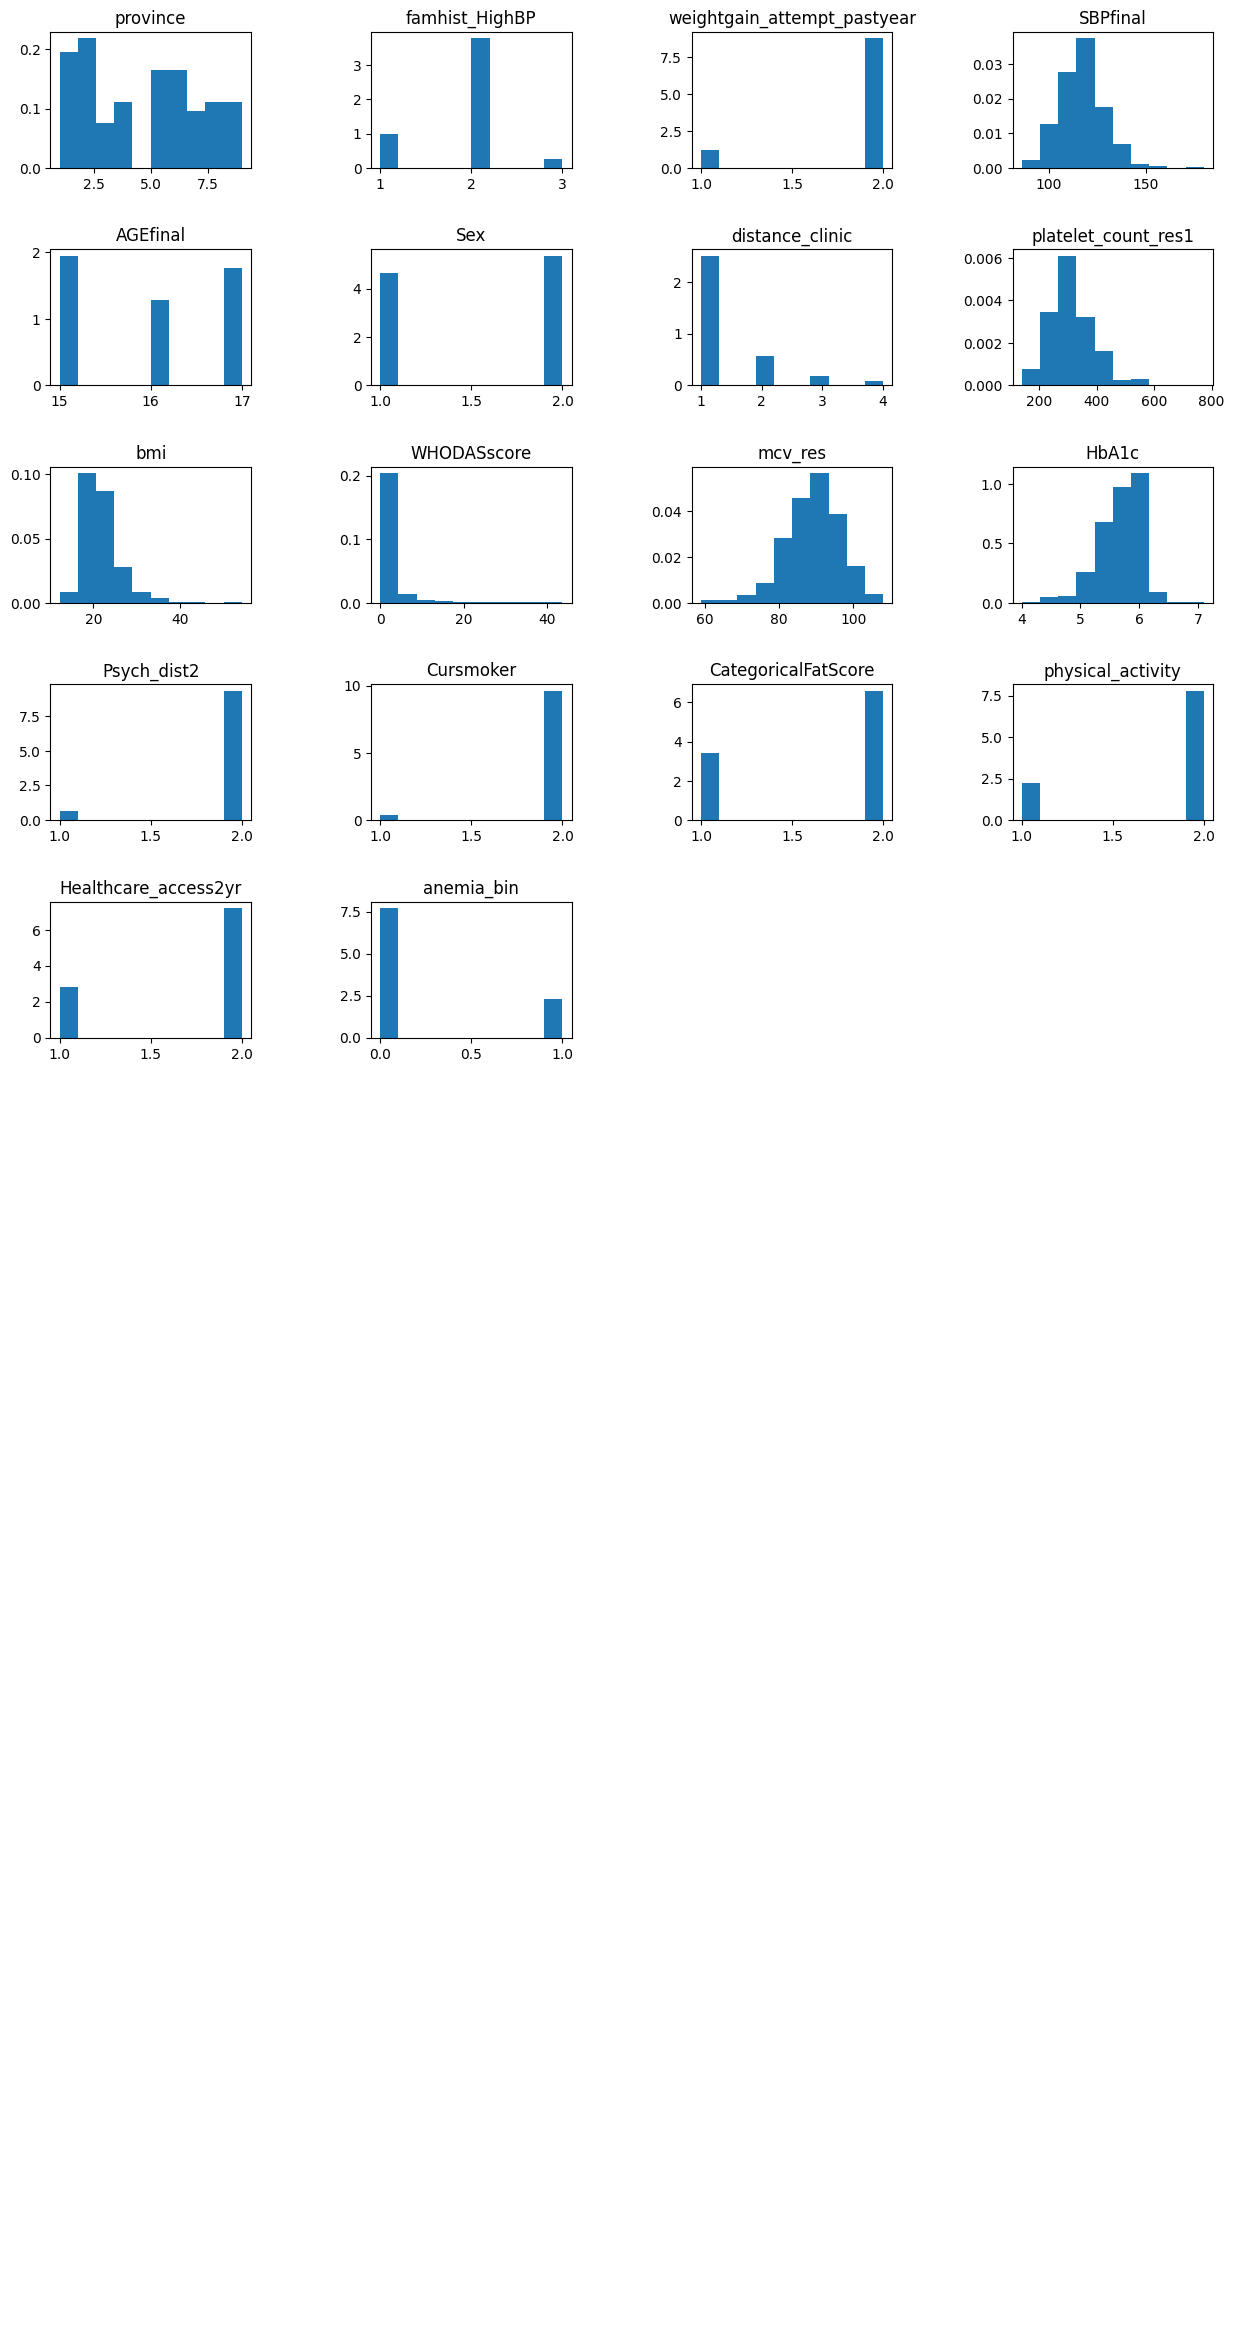

In [ ]:
# Create the figure and subplots
fig, axs = plt.subplots(11, 4, figsize=(15, 30))

# Flatten the axs array to make it easier to iterate through
axs = axs.flatten()

# Loop through each feature and plot a histogram in a separate subplot
for i, col in enumerate(df_copy.columns):
    axs[i].hist(df_copy[col], density = True, bins=10)
    axs[i].set_title(col)

# Hide any unused subplots
for i in range(len(df_copy.columns), 11 * 4):
    axs[i].axis('off')

# Add a main title and adjust the spacing between subplots
#plt.suptitle('Histograms for Multiple Features')
plt.subplots_adjust(hspace=0.6, wspace=0.6)
#fig.suptitle("Histogram for the features", fontsize = 30)

# Show the plot
plt.show()

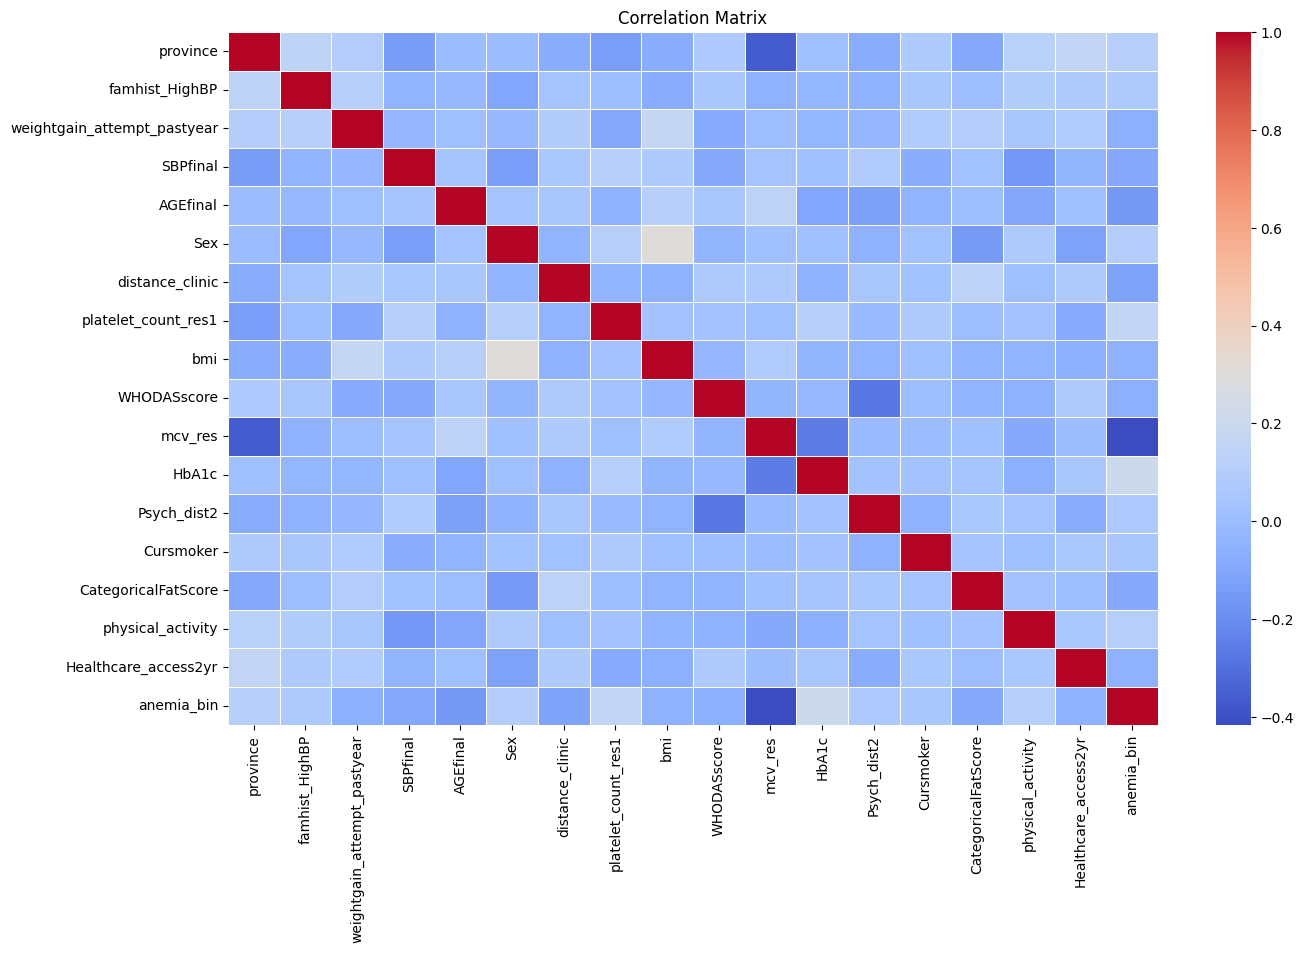

In [ ]:
# Create the correlation matrix
correlation_matrix = df_copy.corr()

# Set up the matplotlib figure
plt.figure(figsize=(15, 9))

# Plot the correlation matrix
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f", linewidths=0.5)

# Add title
plt.title('Correlation Matrix')

# Show plot
plt.show()


From the heatmap we don't really have highly correlated features

In [ ]:
# Calculate the correlation matrix
corr_matrix = df_copy.corr().unstack().sort_values().drop_duplicates()
# Display the correlation matrix
print(corr_matrix)

mcv_res              anemia_bin                    -0.416584
                     province                      -0.362758
Psych_dist2          WHODASscore                   -0.268415
mcv_res              HbA1c                         -0.258409
SBPfinal             physical_activity             -0.159486
                                                      ...   
platelet_count_res1  anemia_bin                     0.164161
bmi                  weightgain_attempt_pastyear    0.171003
anemia_bin           HbA1c                          0.207478
bmi                  Sex                            0.305533
province             province                       1.000000
Length: 154, dtype: float64


<font color='blue' size="+3">Splitting data into Training and Testing samples</font>


In [ ]:
X = df_copy.drop(["anemia_bin"], axis=1) #independent
y = df_copy.anemia_bin #dependent



In [ ]:
# Split the data into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=120)

In [ ]:
# Quick sanity check with the shapes of Training and testing datasets
print("X_train - ",X_train.shape)
print("y_train - ",y_train.shape)
print("X_test - ",X_test.shape)
print("y_test - ",y_test.shape)

X_train -  (345, 17)
y_train -  (345,)
X_test -  (148, 17)
y_test -  (148,)


<font color='blue' size="+3">Models Used</font>

We will train four types of classifiers and decide which classifier will be more effective in detecting anemic condition.

We will use:
**Classification Models**

1. Random Forest
2. Adaptive Boosting( AdaBoost)
3. Gradient Boost
4. XGBoost
5. CatBoost

<font color='blue' size="+3">Model Building</font>

We are aware that our dataset is highly imbalanced, however, we check the performance of imbalance dataset first and later we implement some techniques to balance the dataset and again check the performance of balanced dataset. Finally, we will compare each regression models performance.

<font color='blue' size="+1">Standardization</font>

In [ ]:
scaler=StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
X_test

array([[ 1.29649984,  0.30726353,  0.38729833, ...,  0.72098806,
        -1.94722024,  0.64337736],
       [-1.37504207, -1.81285482,  0.38729833, ...,  0.72098806,
         0.51355259,  0.64337736],
       [-0.99339322,  0.30726353,  0.38729833, ...,  0.72098806,
         0.51355259,  0.64337736],
       ...,
       [-0.23009553,  0.30726353,  0.38729833, ...,  0.72098806,
        -1.94722024, -1.55429778],
       [ 0.15155331,  0.30726353,  0.38729833, ..., -1.38698551,
         0.51355259,  0.64337736],
       [-0.99339322,  0.30726353,  0.38729833, ...,  0.72098806,
         0.51355259,  0.64337736]])

In [ ]:
# Define models
models = {
    'Random Forest': RandomForestClassifier(),
    'CatBoost': CatBoostClassifier(verbose=False),
    'AdaBoost': AdaBoostClassifier(),
    'XGBoost': XGBClassifier(),
    'Gradient Boosting': GradientBoostingClassifier()
}


import pandas as pd

# Train and evaluate models
results = []
for name, model in models.items():
    print("Training", name)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Evaluate model
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)
    balanced_acc = balanced_accuracy_score(y_test, y_pred)
    kappa = cohen_kappa_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    results.append({
        'Model': name,
        'Accuracy Score': accuracy,
        'Roc_Auc_score': roc_auc,
        'MCC': mcc,
        'Balanced_Acc': balanced_acc,
        'Cohen_Kappa': kappa,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    })

# Create DataFrame from results
results_df = pd.DataFrame(results)

Training Random Forest
Training CatBoost
Training AdaBoost
Training XGBoost
Training Gradient Boosting


In [ ]:
results_df.sort_values(by="MCC", ascending=False)

Model  Accuracy Score  Roc_Auc_score       MCC  Balanced_Acc  \
1           CatBoost        0.817568       0.675181  0.422373      0.675181   
0      Random Forest        0.817568       0.664861  0.414636      0.664861   
4  Gradient Boosting        0.804054       0.666409  0.386437      0.666409   
2           AdaBoost        0.777027       0.638545  0.311093      0.638545   
3            XGBoost        0.770270       0.634159  0.296603      0.634159   

   Cohen_Kappa  Precision    Recall  F1 Score  
1     0.404648   0.666667  0.411765  0.509091  
0     0.390110   0.684211  0.382353  0.490566  
4     0.375437   0.608696  0.411765  0.491228  
2     0.305461   0.520000  0.382353  0.440678  
3     0.292463   0.500000  0.382353  0.433333

<font color='blue' size="+3">Confusion Matrix</font>

Training Random Forest


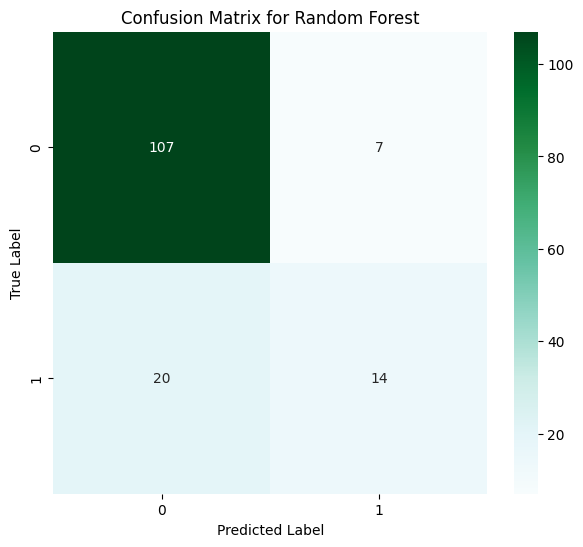

Training CatBoost


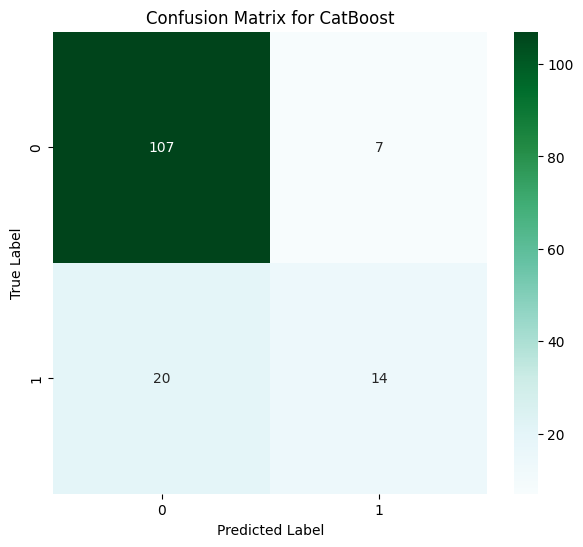

Training AdaBoost


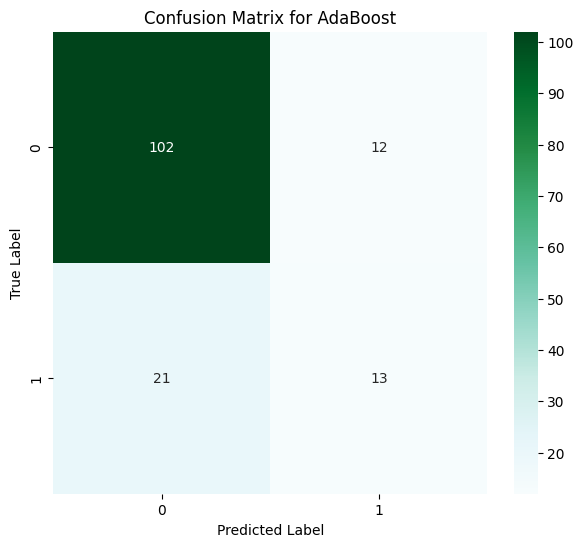

Training XGBoost


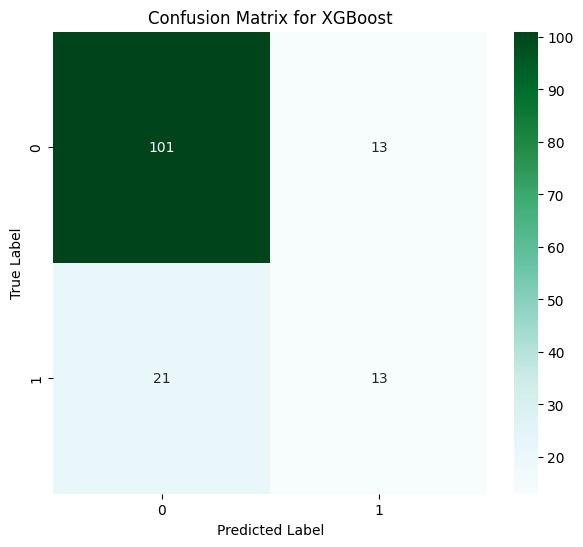

Training Gradient Boosting


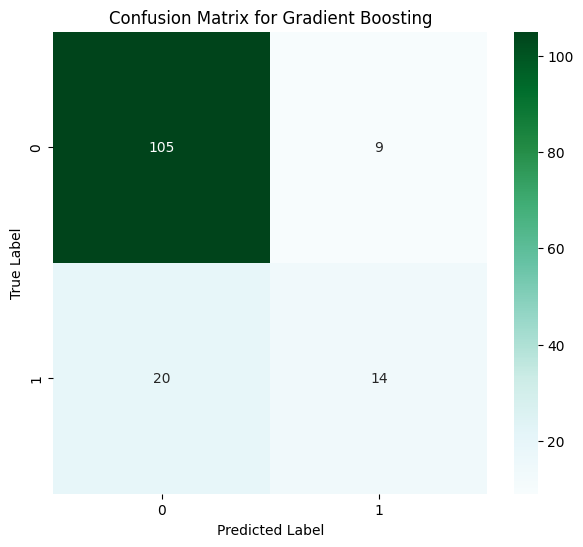

In [ ]:
confusion_matrices = {}  # Store confusion matrices for each model
for name, model in models.items():
    print("Training", name)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    confusion_matrices[name] = cm

    plt.figure(figsize=(7, 6))
    sns.heatmap(cm, annot=True, fmt='d',cmap='BuGn')
    plt.title(f"Confusion Matrix for {name}")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()



<font color='blue' size="+3">ROC Curve</font>



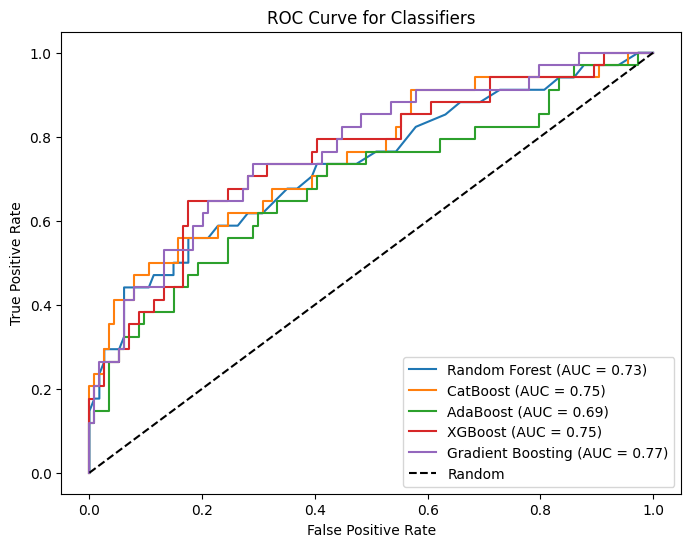

In [ ]:
# Plot ROC curves for each classifier
plt.figure(figsize=(8, 6))

for clf_name, clf in models.items():
    clf.fit(X_train, y_train)
    y_pred_prob = clf.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f'{clf_name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Classifiers')
plt.legend(loc='lower right')
plt.show()


In [ ]:
y_test_series = y_test.squeeze()  # Convert DataFrame to Series
# Get the value counts of the Series
value_counts = y_test_series.value_counts()
print(value_counts)

anemia_bin
0    114
1     34
Name: count, dtype: int64



<font color='blue' size="+3">Class Imbalance</font>



As found in EDA, the response variable anemia_bin have unequal data.


To tackle the imbalance, we will be focuing on



## Random Oversampling
Random oversampling duplicates examples from the minority class in the training dataset and can result in overfitting for some models.



<font color='blue' size="+3">Oversampling</font>



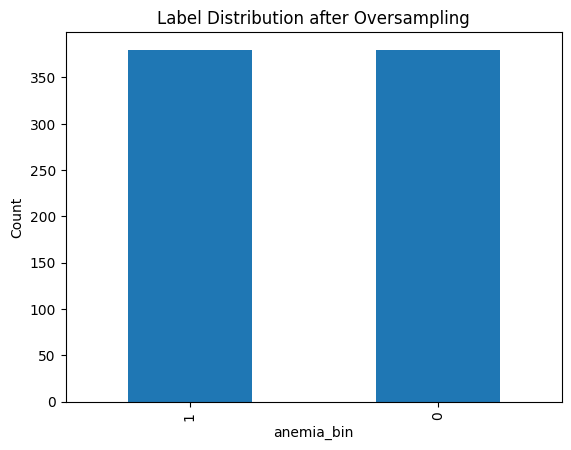

In [ ]:
# over sampling of the dataset to get a balanced dataset
class_0 = df_copy[df_copy['anemia_bin'] == 0]
class_1 = df_copy[df_copy['anemia_bin'] == 1]

# over sampling of the minority class 1
class_1_over = class_1.sample(len(class_0), replace=True)

# Creating a new dataframe with over sampled class 1 df and class 0 df
df_new = pd.concat([class_1_over, class_0], axis=0)

# plotting the new label distribution
df_new['anemia_bin'].value_counts().plot(kind='bar', title='Label Distribution after Oversampling')
plt.ylabel('Count')
plt.show()

In [ ]:
X = df_new.drop('anemia_bin', axis = 1) # features
y = df_new[['anemia_bin']] # labels

# splitting the features and labels into train and test with test size = 20% and train size = 80%
X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.30, random_state=120)

In [ ]:
Store_models_over = [
    ("Random Forest", RandomForestClassifier(random_state=123,)),
    ("AdaBoost", AdaBoostClassifier(random_state=123)),
    ("Gradient Boost", GradientBoostingClassifier(random_state=123)),
    ("XGBoost", XGBClassifier(random_state=123)),
    ("CatBoost", CatBoostClassifier(random_state=123, silent=True)),
]

In [ ]:

Store_model_results_over = pd.DataFrame(columns=["Model", "Accuracy Score"])

In [ ]:
# Initialize an empty list to store results
results_list = []

for clf_name, clf in tqdm(Store_models_over):
    clf.fit(X_train, y_train)
    predictions = clf.predict(X_test)

    score = accuracy_score(y_test, predictions)
    ypred_prob = clf.predict_proba(X_test)[:, 1]
    rocAuc_score = roc_auc_score(y_test, ypred_prob)
    mcc = matthews_corrcoef(y_test, predictions)
    bal_acc = balanced_accuracy_score(y_test, predictions)
    kappa = cohen_kappa_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)

    # Calculate F1 score
    f1 = f1_score(y_test, predictions)

    # Store results in a dictionary
    results_dict = {
        "Model": clf_name,
        "Accuracy Score": score,
        "Roc_Auc_score": rocAuc_score,
        "MCC": mcc,
        "Balanced_Acc": bal_acc,
        "Cohen_Kappa": kappa,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1
    }

    # Append the dictionary to the list
    results_list.append(results_dict)

# Convert the list of dictionaries to a DataFrame
Store_model_results_over = pd.DataFrame(results_list)


100%|██████████| 5/5 [00:02<00:00,  2.08it/s]


In [ ]:
Store_model_results_over.sort_values(by="Precision", ascending=False)

Model  Accuracy Score  Roc_Auc_score       MCC  Balanced_Acc  \
0   Random Forest        0.947368       0.973359  0.895084      0.949844   
4        CatBoost        0.942982       0.979922  0.886797      0.945937   
2  Gradient Boost        0.894737       0.963203  0.793446      0.899687   
3         XGBoost        0.894737       0.983828  0.800330      0.902969   
1        AdaBoost        0.828947       0.900078  0.658119      0.831250   

   Cohen_Kappa  Precision  Recall  F1 Score  
0     0.893822   0.915094    0.97  0.941748  
4     0.885098   0.906542    0.97  0.937198  
2     0.789019   0.839286    0.94  0.886792  
3     0.790377   0.822034    0.97  0.889908  
1     0.656042   0.779817    0.85  0.813397

<font color='blue' size="+3">Confusion Matrix</font>



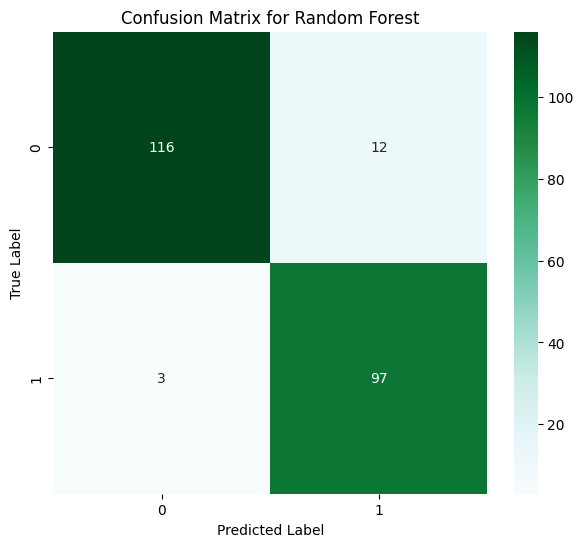

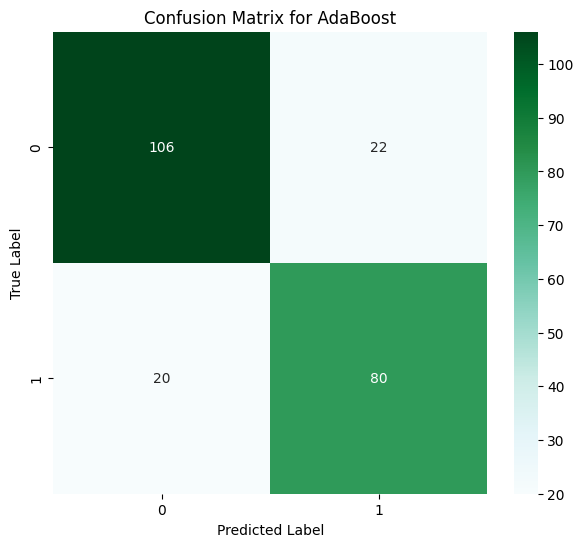

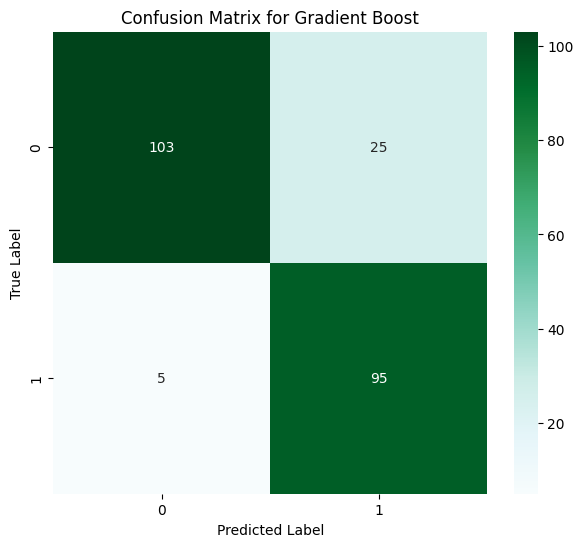

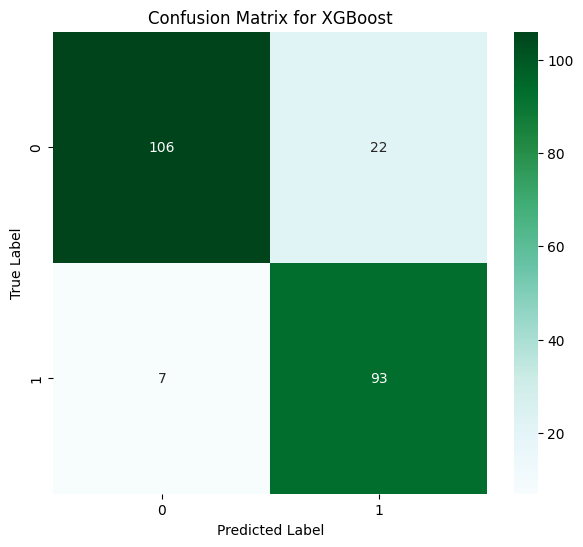

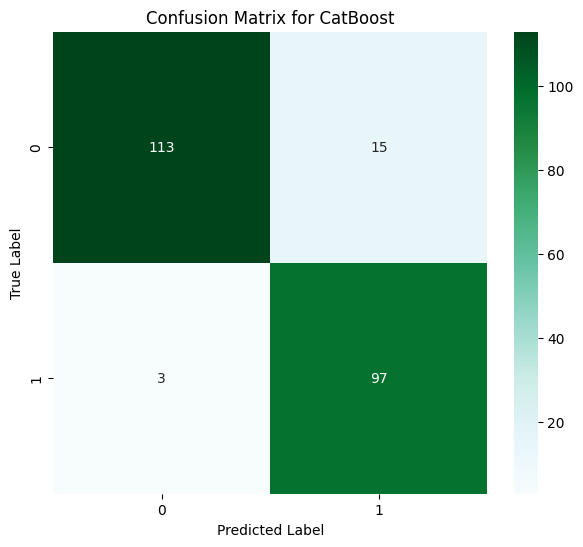

In [ ]:
for model_name, model in Store_models_over:
    # Fit the model with your training data
    model.fit(X_train, y_train)

    # Make predictions on the test set
    predictions = model.predict(X_test)

    # Generate the confusion matrix
    cm = confusion_matrix(y_test, predictions)

    # Plot the confusion matrix using seaborn's heatmap
    plt.figure(figsize=(7, 6))
    sns.heatmap(cm, annot=True, fmt='d',cmap='BuGn')
    plt.title(f"Confusion Matrix for {model_name}")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()


In [ ]:
y_test_series = y_test.squeeze()  # Convert DataFrame to Series
# Get the value counts of the Series
value_counts = y_test_series.value_counts()
print(value_counts)

anemia_bin
0    128
1    100
Name: count, dtype: int64


<font color='blue' size="+3">ROC Curve</font>



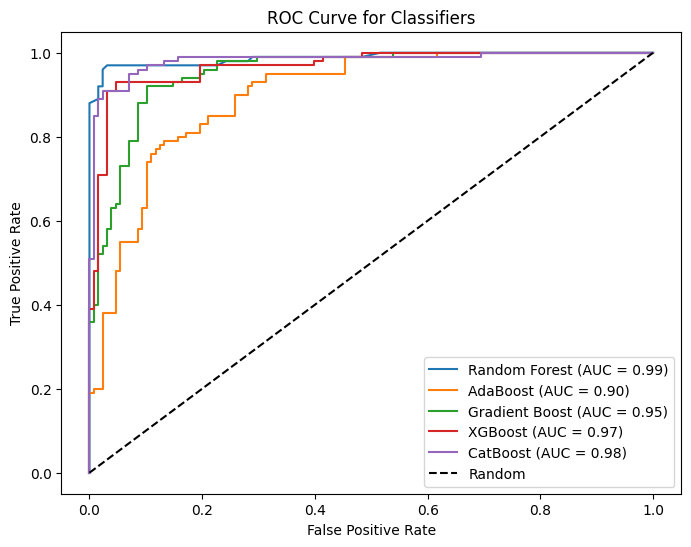

In [ ]:
# Plot ROC curves for each classifier
plt.figure(figsize=(8, 6))

for clf_name, clf in Store_models_over:
    clf.fit(X_train, y_train)
    y_pred_prob = clf.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f'{clf_name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Classifiers')
plt.legend(loc='lower right')
plt.show()

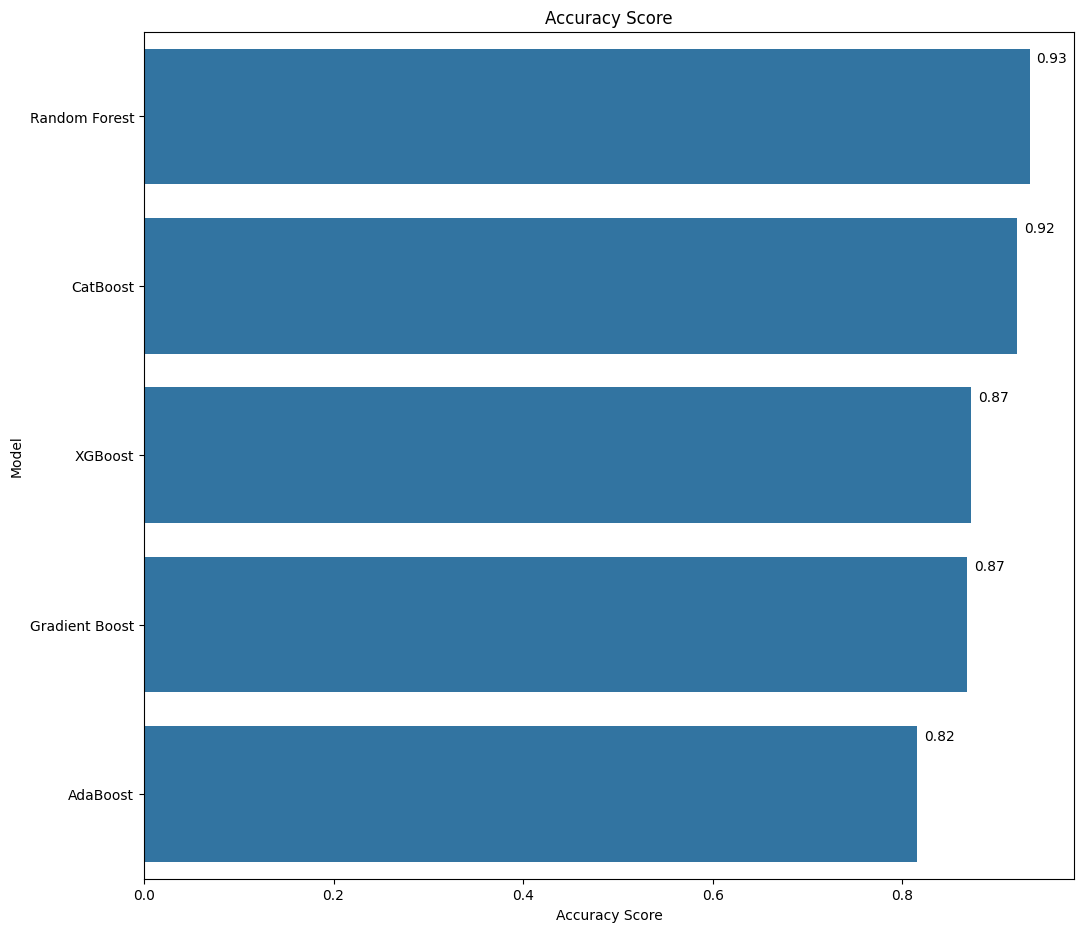

In [ ]:
# Sort the accuracy table
Accuracy_table = Store_model_results_over[["Model", "Accuracy Score"]].sort_values(by="Accuracy Score", ascending=False)

# Create the barplot
fig, ax = plt.subplots(figsize=(12, 11))
sns.barplot(y='Model', x='Accuracy Score', data=Accuracy_table, ax=ax).set(title="Accuracy Score")

# Add labels to the bars
for p in ax.patches:
    ax.annotate(f'{p.get_width():.2f}',
                ((p.get_x() + p.get_width()), p.get_y()),
                xytext=(5, -10),
                textcoords='offset points')

plt.show()

<font color='blue' size="+2">Feature Importance of the Top  Models using the MCC evaluation metrics</font>



**Random Forest Classifier**

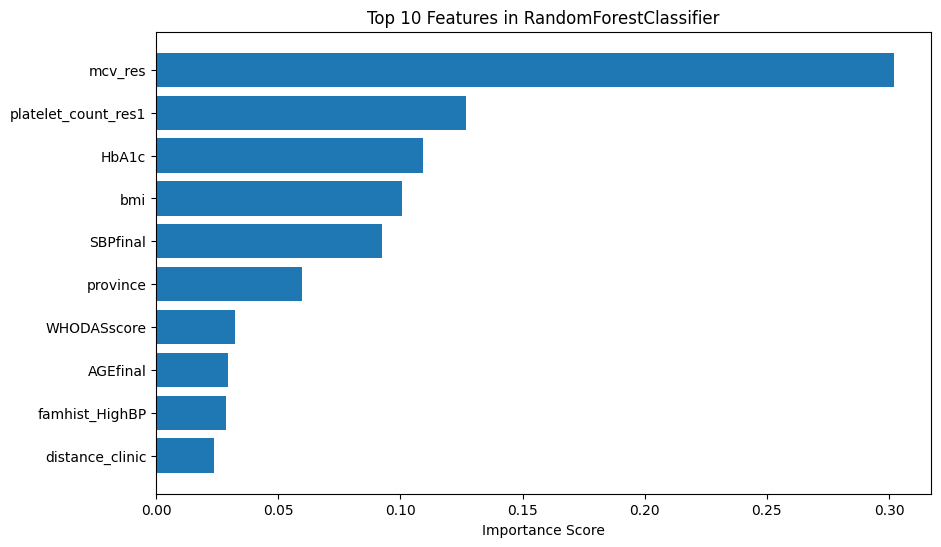

In [ ]:
# Initialize RandomForestClassifier
random_forest = RandomForestClassifier(random_state=123)  # Adjust parameters as needed

# Train the model
random_forest.fit(X_train, y_train)

# Get feature importances from the trained model
importances = random_forest.feature_importances_

# Get the indices of the top 10 features with the highest importance scores
indices = np.argsort(importances)[-10:]

# Plot the top 10 features with their importance scores in a bar chart
plt.figure(figsize=(10, 6))
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [X.columns[i] for i in indices])
plt.xlabel('Importance Score')
plt.title('Top 10 Features in RandomForestClassifier')
plt.show()


**CatBoost Classifier**

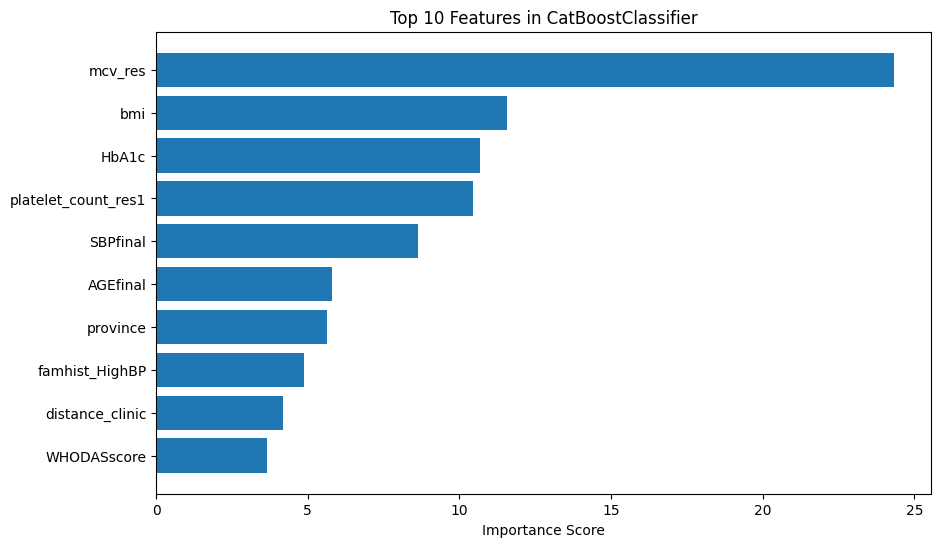

In [ ]:
# Initialize CatBoostClassifier
catboost = CatBoostClassifier(random_state=123)

# Train the model
catboost.fit(X_train, y_train, verbose=False)

# Get feature importances from the trained model
importances = catboost.feature_importances_

# Get the indices of the top 10 features with the highest importance scores
indices = np.argsort(importances)[-10:]

# Plot the top 10 features with their importance scores in a bar chart
plt.figure(figsize=(10, 6))
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [X.columns[i] for i in indices])
plt.xlabel('Importance Score')
plt.title('Top 10 Features in CatBoostClassifier')
plt.show()


# Plotting the Accuracy Scores

In [ ]:
Accuracy_table = Store_model_results_over[["Model","Accuracy Score"]].sort_values(by = "Accuracy Score", ascending = False)
Accuracy_table

Model  Accuracy Score
0   Random Forest        0.934211
4        CatBoost        0.921053
3         XGBoost        0.872807
2  Gradient Boost        0.868421
1        AdaBoost        0.815789

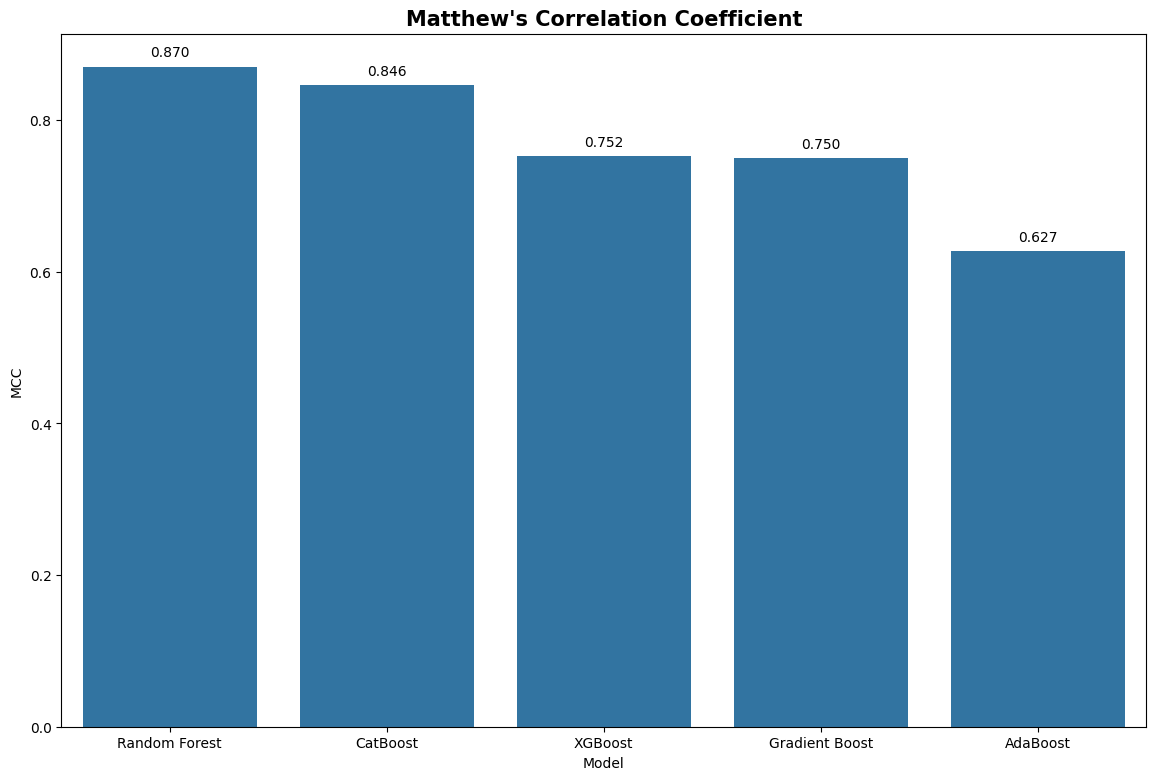

In [ ]:
MCC_table = Store_model_results_over[["Model", "MCC"]].sort_values(by="MCC", ascending=False)
fig, ax = plt.subplots(figsize=(14, 9))

# drawing the plot
sns.barplot(x='Model', y='MCC', data=MCC_table, ax=ax)
plt.title("Matthew's Correlation Coefficient", fontweight='bold', fontsize=15)

# Add labels to the bars
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.3f'),
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha = 'center', va = 'center',
                   xytext = (0, 10),
                   textcoords = 'offset points')

plt.show()


<font color='blue' size="+3"> LIME</font>


**Random Forest Explainer**

In [ ]:

instance_to_explain = X_test.iloc[0]

# Define your feature names with labels
feature_names_with_labels = list(X_train.columns)
feature_names_with_labels.append("Anemic")

# Create a LIME explainer for tabular data with feature names including labels
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, mode="classification", feature_names=feature_names_with_labels, class_names=['Non Anemic', 'Anemic'])

# Explain the model's prediction for the chosen instance
explanation = explainer.explain_instance(instance_to_explain.values, random_forest.predict_proba, num_features=10)

# Display the explanation
explanation.show_in_notebook()


**CatBoost Explainer**

In [ ]:

instance_to_explain = X_test.iloc[0]

# Define your feature names with labels
feature_names_with_labels = list(X_train.columns)
feature_names_with_labels.append("Anemic")

# Create a LIME explainer for tabular data with feature names including labels
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, mode="classification", feature_names=feature_names_with_labels, class_names=['Non Anemic', 'Anemic'])

# Explain the model's prediction for the chosen instance
explanation = explainer.explain_instance(instance_to_explain.values, catboost.predict_proba, num_features=10)

# Display the explanation
explanation.show_in_notebook()


<font color='blue' size="+3"> Permutation Feature Importance</font>


**CatBoost PFI**


Permutation Feature Importances:
CategoricalFatScore: -0.0047
Sex: -0.0042
weightgain_attempt_pastyear: -0.0029
Healthcare_access2yr: -0.0006
Psych_dist2: -0.0003
Cursmoker: -0.0002
WHODASscore: 0.0021
physical_activity: 0.0089
AGEfinal: 0.0157
famhist_HighBP: 0.0175
province: 0.0218
SBPfinal: 0.0233
distance_clinic: 0.0246
HbA1c: 0.0336
bmi: 0.0461
platelet_count_res1: 0.0501
mcv_res: 0.1865


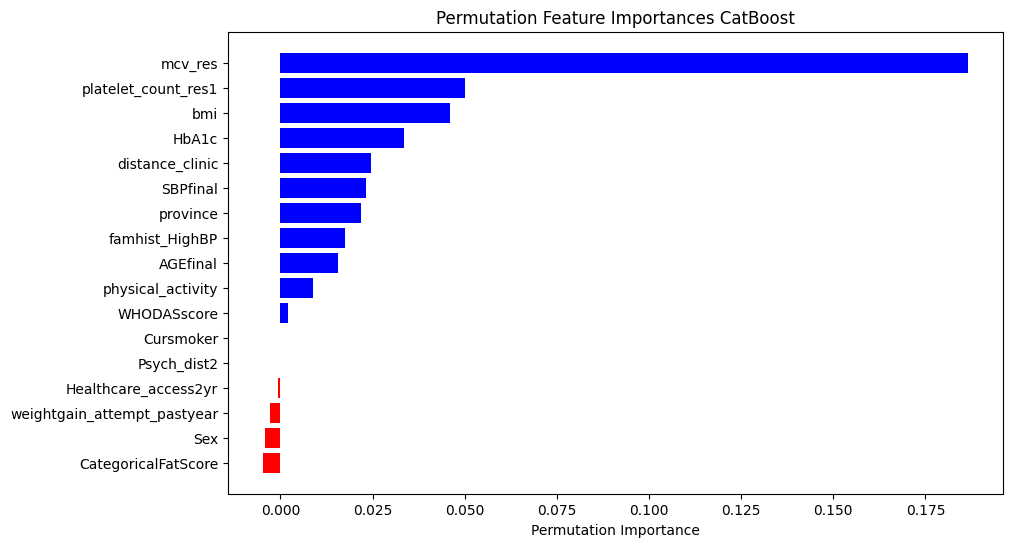

In [ ]:
clf = CatBoostClassifier(random_state=123)

# Train the model
clf.fit(X_train, y_train, verbose=False)
#clf.fit(X_train_resampled, y_train_resampled, verbose=False)



# Evaluate the model's accuracy on the test set
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
#print("Accuracy of the model:", accuracy)

# Function to calculate permutation feature importance
def permutation_importance(model, X, y, metric, num_iterations=100):
    baseline_score = metric(y, model.predict(X))
    importances = {}
    for col in X.columns:
        importance_scores = []
        for _ in range(num_iterations):
            X_permuted = X.copy()
            X_permuted[col] = np.random.permutation(X_permuted[col])
            permuted_score = metric(y, model.predict(X_permuted))
            #importance_scores.append(permuted_score - baseline_score)
            importance_scores.append(baseline_score - permuted_score)
        importances[col] = np.mean(importance_scores)
    return importances

# Calculate permutation feature importance
importances = permutation_importance(clf, X_test, y_test, accuracy_score)

# Sort feature importances
sorted_importances = {k: v for k, v in sorted(importances.items(), key=lambda item: item[1], reverse=False)}

# Print feature importances
print("\nPermutation Feature Importances:")
for feature, importance in sorted_importances.items():
    print(f"{feature}: {importance:.4f}")

# Plotting feature importances
plt.figure(figsize=(10, 6))

# Assigning colors based on values
colors = ['blue' if v >= 0 else 'red' for v in sorted_importances.values()]

plt.barh(range(len(sorted_importances)), list(sorted_importances.values()), color=colors, align='center')
plt.yticks(range(len(sorted_importances)), list(sorted_importances.keys()))
plt.xlabel('Permutation Importance')
plt.title('Permutation Feature Importances CatBoost')
plt.show()


**Random Forest PFI**


Permutation Feature Importances:
weightgain_attempt_pastyear: -0.0056
distance_clinic: -0.0023
famhist_HighBP: -0.0016
CategoricalFatScore: -0.0008
Cursmoker: 0.0000
Healthcare_access2yr: 0.0000
WHODASscore: 0.0007
Psych_dist2: 0.0038
physical_activity: 0.0038
AGEfinal: 0.0061
Sex: 0.0089
bmi: 0.0142
SBPfinal: 0.0144
province: 0.0171
HbA1c: 0.0251
platelet_count_res1: 0.0388
mcv_res: 0.2014


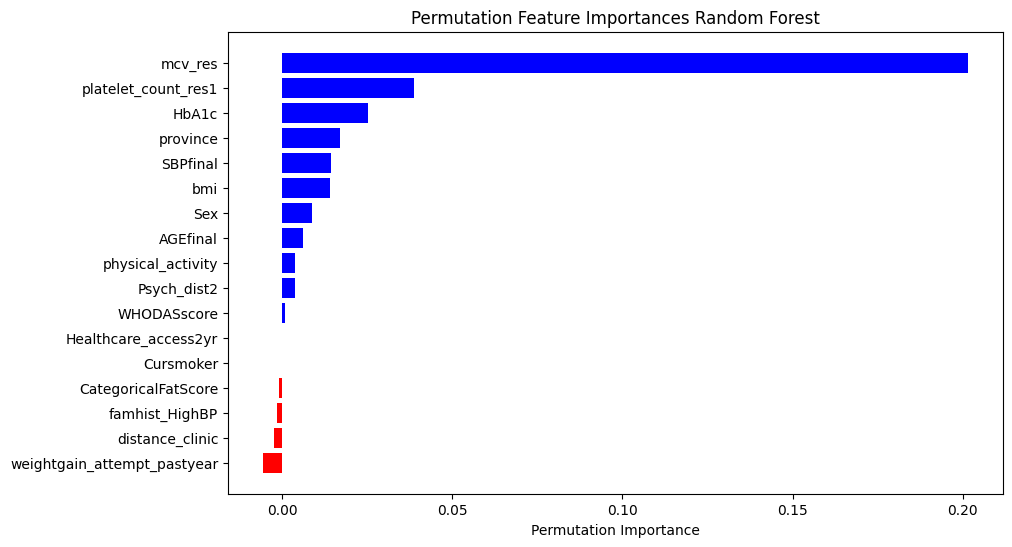

In [ ]:
#Train a random forest classifier
clf = RandomForestClassifier(random_state=123)
# clf.fit(X_train, y_train)


# Train the model
#clf.fit(X_train, y_train)
clf.fit(X_train, y_train)



# Evaluate the model's accuracy on the test set
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
#print("Accuracy of the model:", accuracy)

# Function to calculate permutation feature importance
def permutation_importance(model, X, y, metric, num_iterations=100):
    baseline_score = metric(y, model.predict(X))
    importances = {}
    for col in X.columns:
        importance_scores = []
        for _ in range(num_iterations):
            X_permuted = X.copy()
            X_permuted[col] = np.random.permutation(X_permuted[col])
            permuted_score = metric(y, model.predict(X_permuted))
            #importance_scores.append(permuted_score - baseline_score)
            importance_scores.append(baseline_score - permuted_score)
        importances[col] = np.mean(importance_scores)
    return importances

# Calculate permutation feature importance
importances = permutation_importance(clf, X_test, y_test, accuracy_score)

# Sort feature importances
sorted_importances = {k: v for k, v in sorted(importances.items(), key=lambda item: item[1], reverse=False)}

# Print feature importances
print("\nPermutation Feature Importances:")
for feature, importance in sorted_importances.items():
    print(f"{feature}: {importance:.4f}")

# Plotting feature importances
plt.figure(figsize=(10, 6))

# Assigning colors based on values
colors = ['blue' if v >= 0 else 'red' for v in sorted_importances.values()]

plt.barh(range(len(sorted_importances)), list(sorted_importances.values()), color=colors, align='center')
plt.yticks(range(len(sorted_importances)), list(sorted_importances.keys()))
plt.xlabel('Permutation Importance')
plt.title('Permutation Feature Importances Random Forest')
plt.show()
